# Test for bike trafic model

## INIT

In [5]:
import sys
from pathlib import Path

CURRENT_DIR = Path().resolve().parents[0]
DATA_DIR = CURRENT_DIR / "data"
SRC_PATH = CURRENT_DIR / "src"
if str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import matplotlib.cm as cm
from matplotlib.lines import Line2D

from aequilibrae.paths import RouteChoice
from aequilibrae.matrix import AequilibraeMatrix
import warnings

warnings.filterwarnings('ignore')

from utils_sta import ta_due
import logging
logging.getLogger("aequilibrae").setLevel(logging.ERROR)

In [97]:
#### plotting functions
def _create_offset_polygon(coords, width):
    """Create polygon offset to right of line. From utils_traffic.py by Bahman"""
    if len(coords) < 2:
        return None

    right_pts, left_pts = [], []
    for i, (cx, cy) in enumerate(coords):
        if i == 0:
            dx, dy = coords[1][0] - coords[0][0], coords[1][1] - coords[0][1]
        elif i == len(coords) - 1:
            dx, dy = coords[-1][0] - coords[-2][0], coords[-1][1] - coords[-2][1]
        else:
            dx = (coords[i + 1][0] - coords[i - 1][0]) / 2
            dy = (coords[i + 1][1] - coords[i - 1][1]) / 2

        length = np.sqrt(dx ** 2 + dy ** 2)
        if length > 0:
            dx, dy = dx / length, dy / length

        perp_x, perp_y = dy, -dx
        right_pts.append((cx + perp_x * width, cy + perp_y * width))
        left_pts.append((cx, cy))

    try:
        polygon = Polygon(right_pts + left_pts[::-1])
        return polygon if polygon.is_valid else polygon.buffer(0)
    except:
        return None

def plot_network(edges_df, nodes_df, ax=None, figsize=(10,10), node_x_col='x', node_y_col='y', 
                 width_col=None, base_width=0.1, width_scale=2.1, node_id_col='node', color_col_num=None, color_col_str=None, dict_colors_str=None,
                 vmin=None, vmax=None, a_node_col='a_node', b_node_col='b_node', show_nodes=True,
                 node_size=100, cmap='viridis', colorbar_label=None, title=None, node_label=False, legend=False, edges_label_col=None):
    
    """ Plot a network with edge widths and colors based on specified columns. Adapted from utils_traffic.py by Bahman """

    edges_df = edges_df.reset_index(drop=True)

    if dict_colors_str is not None:
        dict_colors = dict_colors_str
    else:
        dict_colors = {'bike_path': '#4E9F50FF', 'bike_lane': '#EF8A0CFF', 'none':'black'}
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    x_range = nodes_df[node_x_col].max() - nodes_df[node_x_col].min()
    y_range = nodes_df[node_y_col].max() - nodes_df[node_y_col].min()
    scale = min(x_range, y_range) / 100

    scaled_base = scale * base_width
    scaled_scale = scale * width_scale * 0.0001

    node_coords = {r[node_id_col]: (r[node_x_col], r[node_y_col])
                   for _, r in nodes_df.iterrows()}
    
    if width_col is not None:
        width_vals = edges_df[width_col].fillna(0).values if width_col in edges_df.columns else np.ones(len(edges_df))
        if color_col_num is None:
            color_col_num = width_col
    
    if color_col_num in edges_df.columns:
        color_vals = edges_df[color_col_num].fillna(0).values

        # Use provided vmin/vmax or compute from data
        if vmin is None:
            vmin = np.nanmin(color_vals)
        if vmax is None:
            vmax = np.nanmax(color_vals)
        if vmin == vmax:
            vmax = vmin + 1

        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        use_cmap = True
    else:
        use_cmap = False
    
    if color_col_str in edges_df.columns:
        color_vals = []
        for edge in edges_df.itertuples():
            color_vals.append(dict_colors.get(getattr(edge, color_col_str), 'black'))
        use_cmap = False
    
    if color_col_num is None and color_col_str is None:
        color_vals = ['black'] * len(edges_df)
        use_cmap = False
        
    # Use enumerate to get integer index for numpy array access
    for idx, edge in edges_df.iterrows():
        a_coords = node_coords.get(edge[a_node_col])
        b_coords = node_coords.get(edge[b_node_col])
        if a_coords is None or b_coords is None:
            continue

        # Use idx (which is now 0..N-1 due to reset_index) to access arrays
        if width_col is not None:
            width = scaled_base + width_vals[idx] * scaled_scale
        else:
            width = scaled_base
        polygon = _create_offset_polygon([a_coords, b_coords], width)

        if polygon:
            color = sm.to_rgba(color_vals[idx]) if use_cmap else color_vals[idx]
            x, y = polygon.exterior.xy
            ax.fill(x, y, color=color, alpha=1, edgecolor='black', linewidth=0.1)

    if show_nodes:
        ax.scatter(nodes_df[node_x_col], nodes_df[node_y_col], s=node_size, c='white', zorder=5, edgecolors='black')
        if node_label :
            for _, row in nodes_df.iterrows():
                ax.text(row[node_x_col], row[node_y_col], str(int(row[node_id_col])), fontsize=8,
                        ha='center', va='center', zorder=6)

    if legend and color_col_str is not None:
        legend_elements = []
        for key, color in dict_colors.items():
            legend_elements.append(Line2D([0], [0], color=color, lw=4, label=key))
        ax.legend(handles=legend_elements, loc='lower right')
        
    if use_cmap:
        # Determine colorbar label
        if colorbar_label is None:
            colorbar_label = color_col_num.replace('_', ' ').title()
        cbar = plt.colorbar(sm, ax=ax, label=colorbar_label, shrink=0.8)

    if edges_label_col is not None and edges_label_col in edges_df.columns:
        for _, edge in edges_df.iterrows():
            a_coords = node_coords.get(edge[a_node_col])
            b_coords = node_coords.get(edge[b_node_col])
            if a_coords is None or b_coords is None:
                continue
            mid_x = (a_coords[0] + b_coords[0]) / 2
            mid_y = (a_coords[1] + b_coords[1]) / 2
            if a_coords[0] == b_coords[0]:  # horizontal line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white', rotation='vertical')
            else:  # vertical line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white')
            
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title or f'Network (width by {width_col})')
    plt.tight_layout()
    
    if ax is None:
        return fig, ax

def plot_od_matrix(od_matrix, edges_df, nodes_df, ax=None, figsize=(10,10), cmap='viridis', title='OD Matrix', label=True, color='red', vmax=None):
    """ Plot OD matrix as arrows on the network."""
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    plot_network(edges_df, nodes_df, ax=ax, show_nodes=True, node_label=True, node_size=300, title=title)
    od_matrix_plot = od_matrix.copy()[od_matrix['demand']>0]
    if vmax is None:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / od_matrix_plot['demand'].max() * 5
    else:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / vmax * 5
    

    for i, row in od_matrix_plot.iterrows():
        x0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'x'].values[0]
        y0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'y'].values[0]
        x1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'x'].values[0]
        y1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'y'].values[0]

        ax.annotate(
        "",
        xy=(x1, y1),      # destination
        xytext=(x0, y0),  # origine
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            lw=row['linewidth']
        ),
        zorder=3
        )
        if label :
            xm = (x0 + x1-100) / 2
            ym = (y0 + y1+100) / 2
            dx = x1 - x0
            dy = y1 - y0

            # Vecteur perpendiculaire unitaire
            nx = -dy
            ny = dx
            norm = np.sqrt(nx**2 + ny**2)
            nx /= norm
            ny /= norm

            # Distance du décalage (à ajuster si besoin)
            offset = 0.015 * np.hypot(dx, dy)

            # Position finale du texte
            xt = xm + nx * offset
            yt = ym + ny * offset

            # Texte
            ax.text(
                xt, yt,
                str(int(row['demand'])),
                color='black',
                fontsize=9,
                ha='center',
                va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                zorder=4
            )

    if ax is None:
        return fig, ax
    

#### Network preprocessing functions

def calculate_length(node_df, edge_df):
    """ Calculate Euclidean length of edges based on node coordinates. """
    lengths = []
    for edge in edge_df.itertuples():
        a_node = node_df.loc[node_df['node'] == edge.a_node]
        b_node = node_df.loc[node_df['node'] == edge.b_node]
        length = np.sqrt((a_node['x'].values[0] - b_node['x'].values[0])**2 + (a_node['y'].values[0] - b_node['y'].values[0])**2)
        lengths.append(length)
    return edge_df.assign(length=lengths)

def calculate_congested_time(edges_df, free_flow_time_name="free_flow_time", congested_time_name="congested_time", flow_name="flow", capacity_name="capacity", alpha=0.15, beta=4):
    """Calculate congested travel time using BPR function.
    𝑇=𝑇0(1+α(𝑉/𝐶)^β)
    where:
    - 𝑇 is the congested travel time
    - 𝑇0 is the free-flow travel time
    - 𝑉 is the volume (flow)
    - 𝐶 is the capacity
    - α and β are parameters
    """
    edges_df[congested_time_name]=edges_df[free_flow_time_name]*(1+alpha*(edges_df[flow_name]/edges_df[capacity_name])**beta)
    return edges_df
    
### eaquilibrea interface processing

def convert_to_eaquilibrae_od_matrix(od_matrix):
    od_long = od_matrix.stack().reset_index()
    od_long.columns = ["origin", "destination", "demand"]
    return od_long

## Test of TA function

### Importation and preprocessing of the network

In [79]:
edge_df = pd.read_csv(DATA_DIR / "edges_small_grid_2.csv")
node_df = pd.read_csv(DATA_DIR / "nodes_small_grid_2.csv")

edge_df = calculate_length(node_df, edge_df)
edge_df["length"] *= 10 
edge_df["type_bike"] = None
edge_df["speed_bike"] /= 3.6
edge_df["speed_car"] /= 3.6
edge_df["free_flow_time"] = edge_df["length"] / edge_df["speed_car"]
edge_df["congested_time"] = edge_df["free_flow_time"]
edge_df["capacity"] = 3000
edge_df["alpha"] = 0.15
edge_df["beta"] = 4

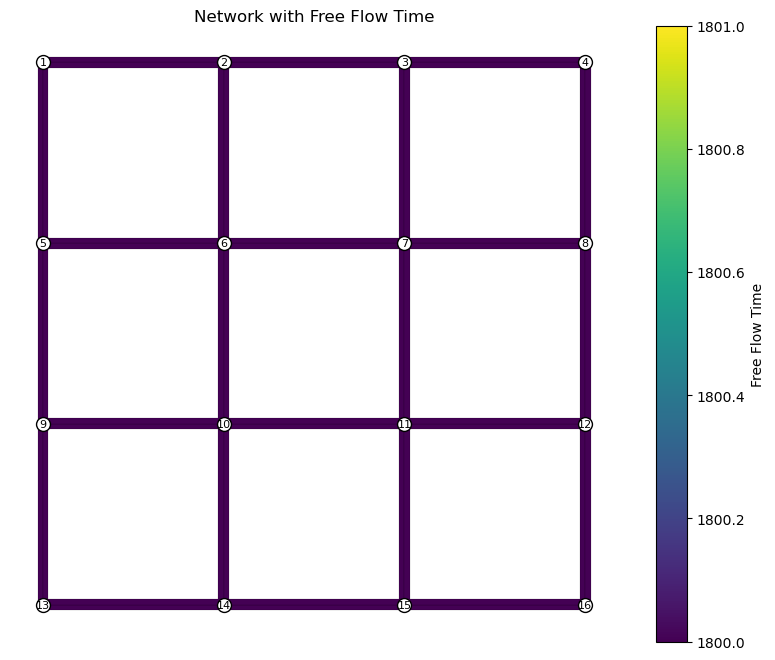

In [80]:
plot_network(edge_df, node_df,
            node_id_col='node',
            node_label=True,
            color_col_num='free_flow_time',
            base_width=1,
            legend=True,
            title="Network with Free Flow Time",
            figsize=(8,8))

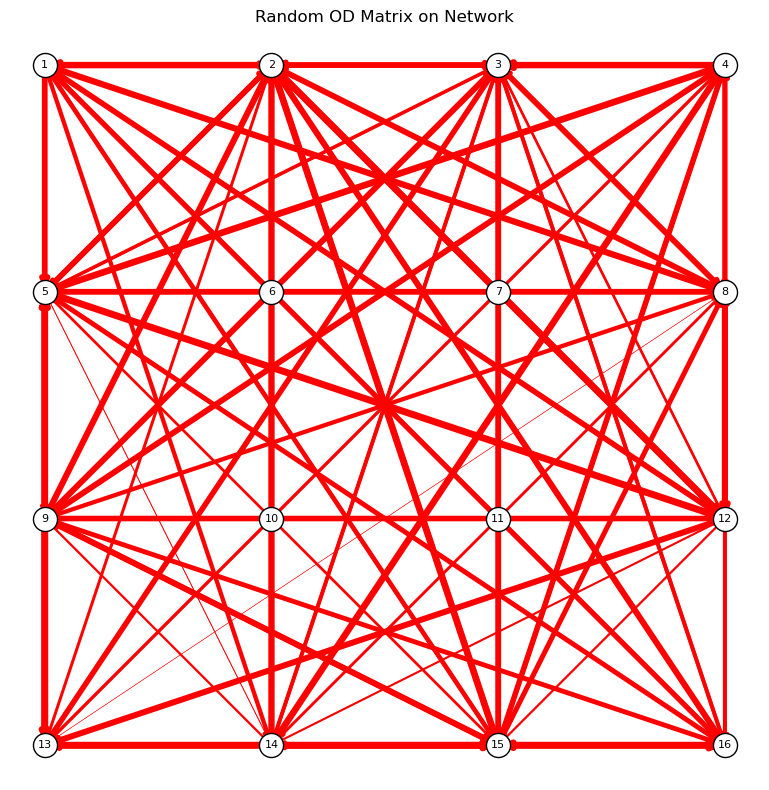

In [91]:
np.random.seed(69)
od_matrix = pd.DataFrame(0, index=range(1,max(node_df['node'])+1), columns=range(1,max(node_df['node'])+1))
liste_i = [1,2,3,4,5,8,9,12,13,15,14,16]
for i in liste_i:
    for j in liste_i:
        if i != j:
            od_matrix.loc[i,j] = np.random.randint(20,2000)

od_matrix = convert_to_eaquilibrae_od_matrix(od_matrix)
plot_od_matrix(od_matrix, edge_df, node_df, title="Random OD Matrix on Network", figsize=(8,8), label=False)

### Test of ta_due

DUE completed in 0.71s | RGAP: 0.000083 | TTT: 10029034639


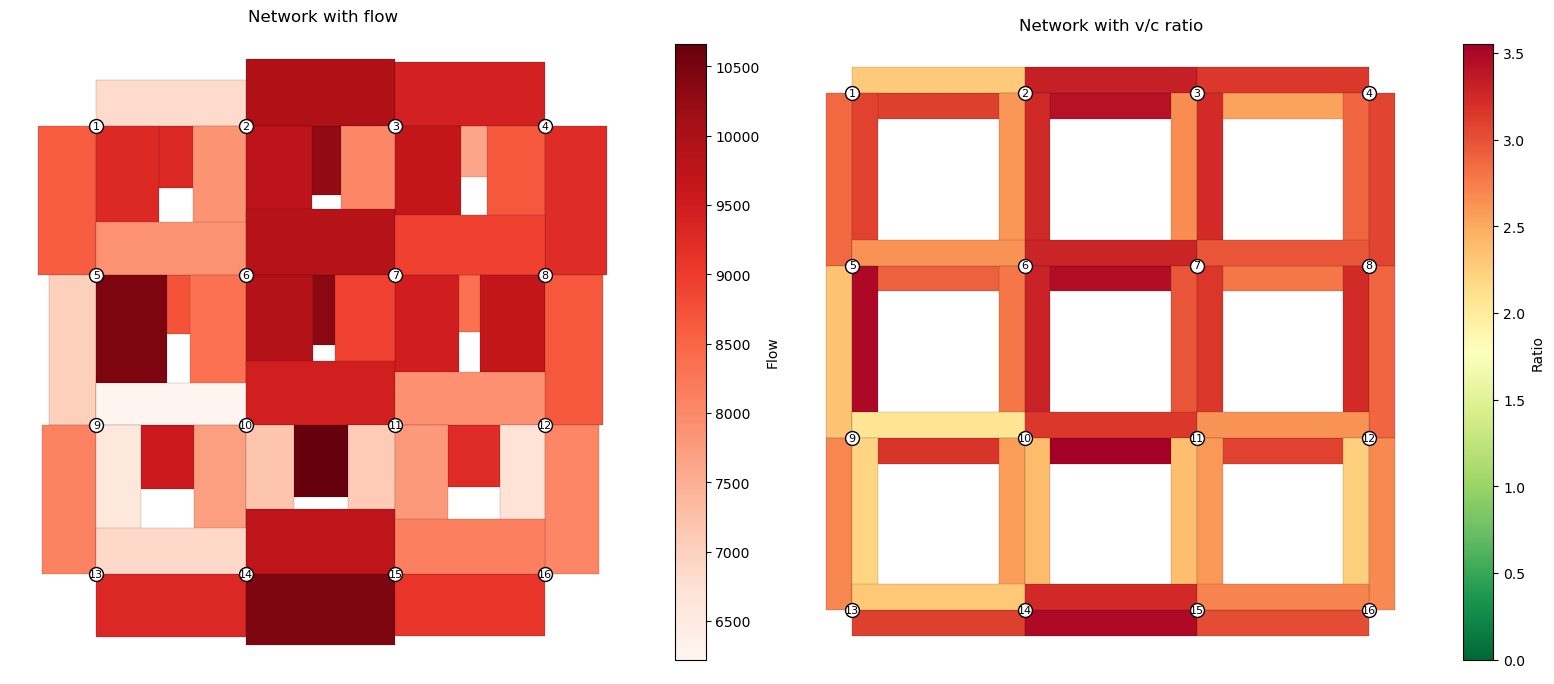

In [92]:
results = ta_due(edge_df, od_matrix, algorithm='bfw', max_iter=500, tolerance=1e-4,
           time_field='free_flow_time', cost_field='free_flow_time', verbose=True)
fig, axes = plt.subplots(1,2, figsize=(16,8))
plot_network(results['network'], node_df,
            node_id_col='node',
            node_label=True,
            color_col_num='flow',
            base_width=0.01,
            width_col='flow',
            width_scale=15,
            legend=True,
            title="Network with flow",
            figsize=(8,8),
            cmap='Reds',
            vmax=results['network']['flow'].max(),
            vmin=results['network']['flow'].min(),
            ax=axes[0])
plot_network(results['network'], node_df,
            node_id_col='node',
            node_label=True,
            color_col_num='ratio',
            base_width=5,
            width_col='ratio',
            width_scale=8,
            legend=True,
            title="Network with v/c ratio",
            figsize=(8,8),
            cmap='RdYlGn_r',
            vmax=results['network']['ratio'].max(),
            vmin=0,
            ax=axes[1])

DUE completed in 1.43s | RGAP: 0.000090 | TTT: 156563564555


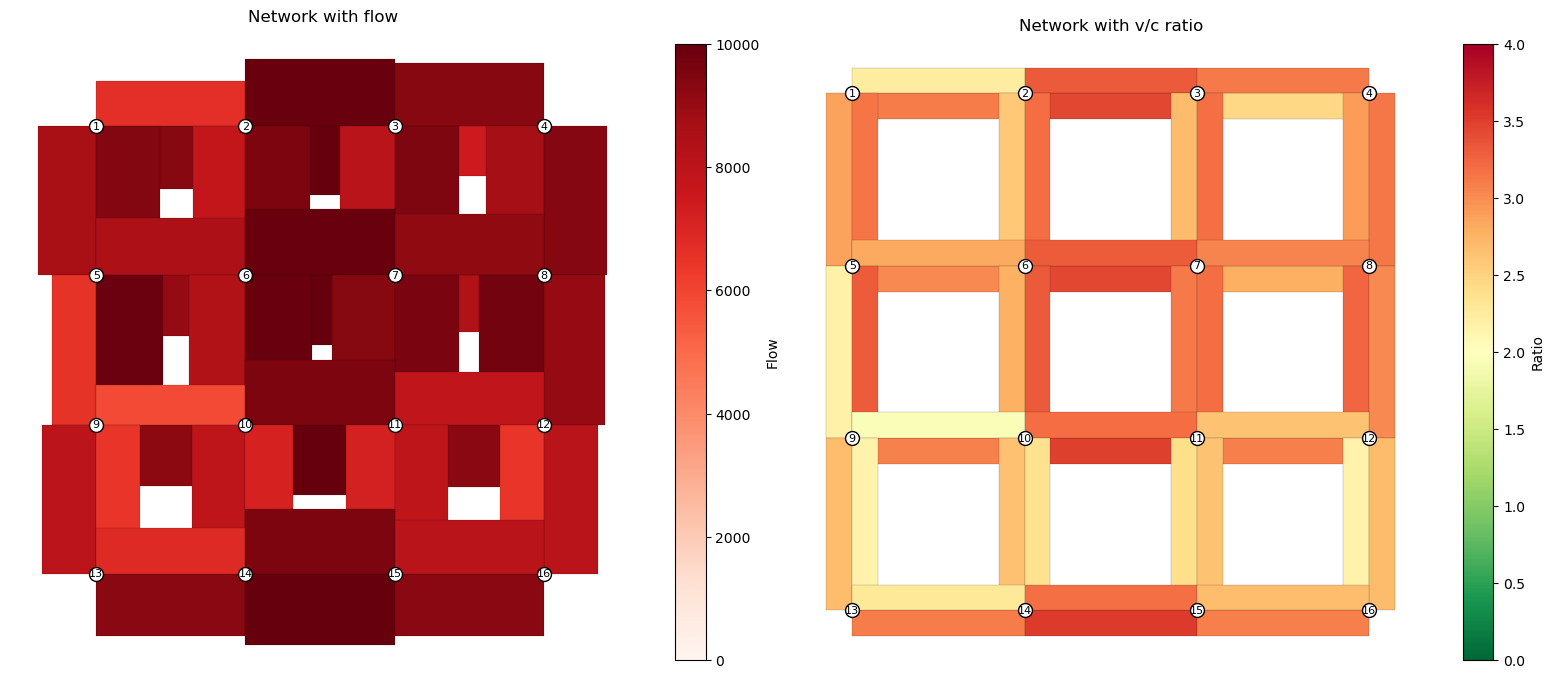

DUE completed in 1.05s | RGAP: 0.000086 | TTT: 156563666487


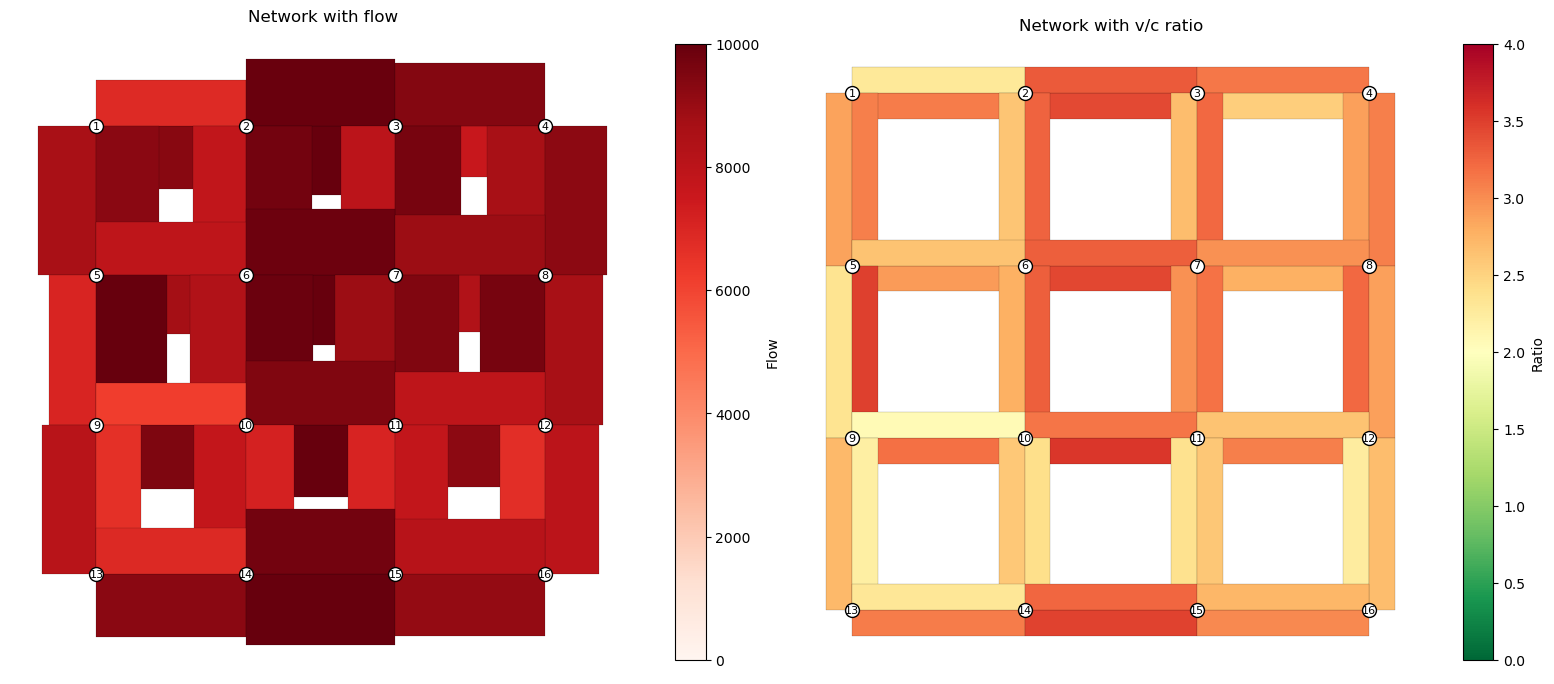

DUE completed in 1.18s | RGAP: 0.000096 | TTT: 156563835868


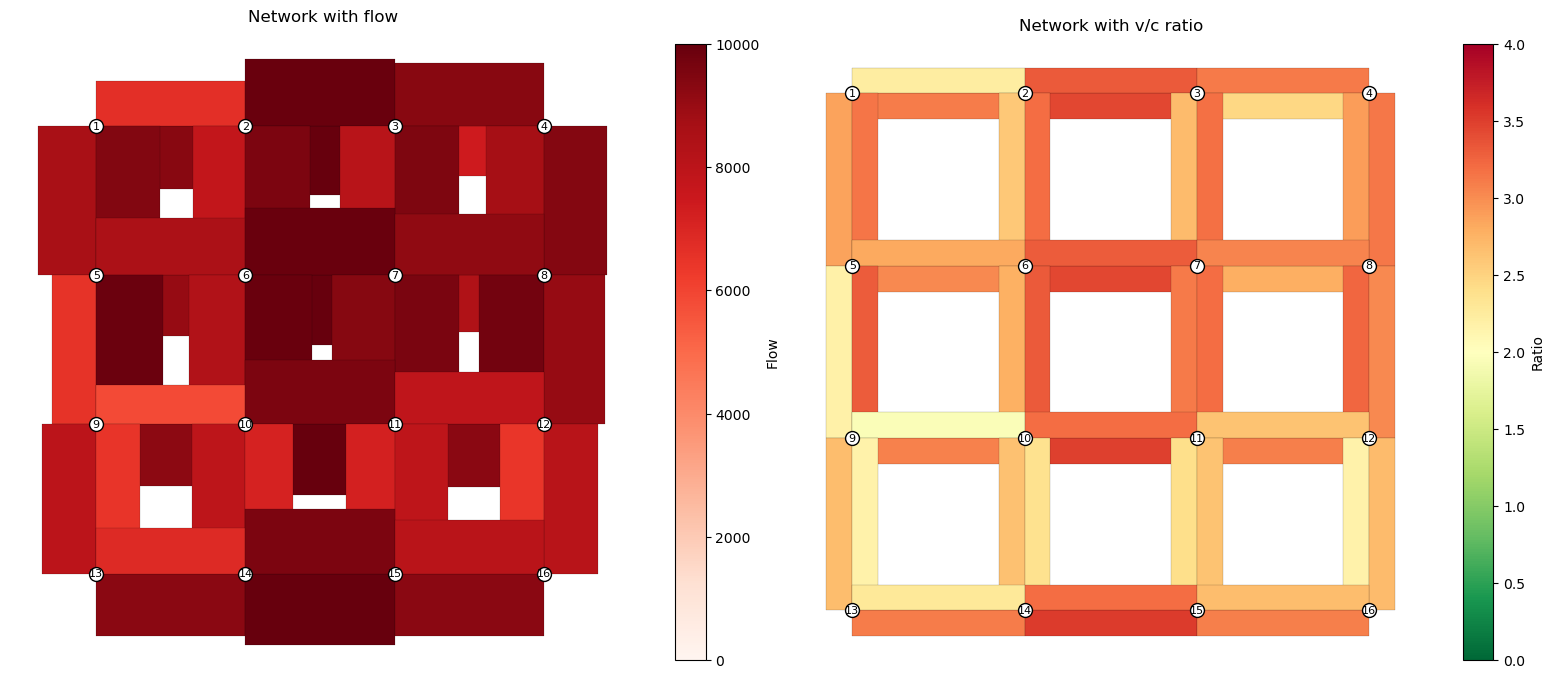

DUE completed in 0.97s | RGAP: 0.000093 | TTT: 156563602475


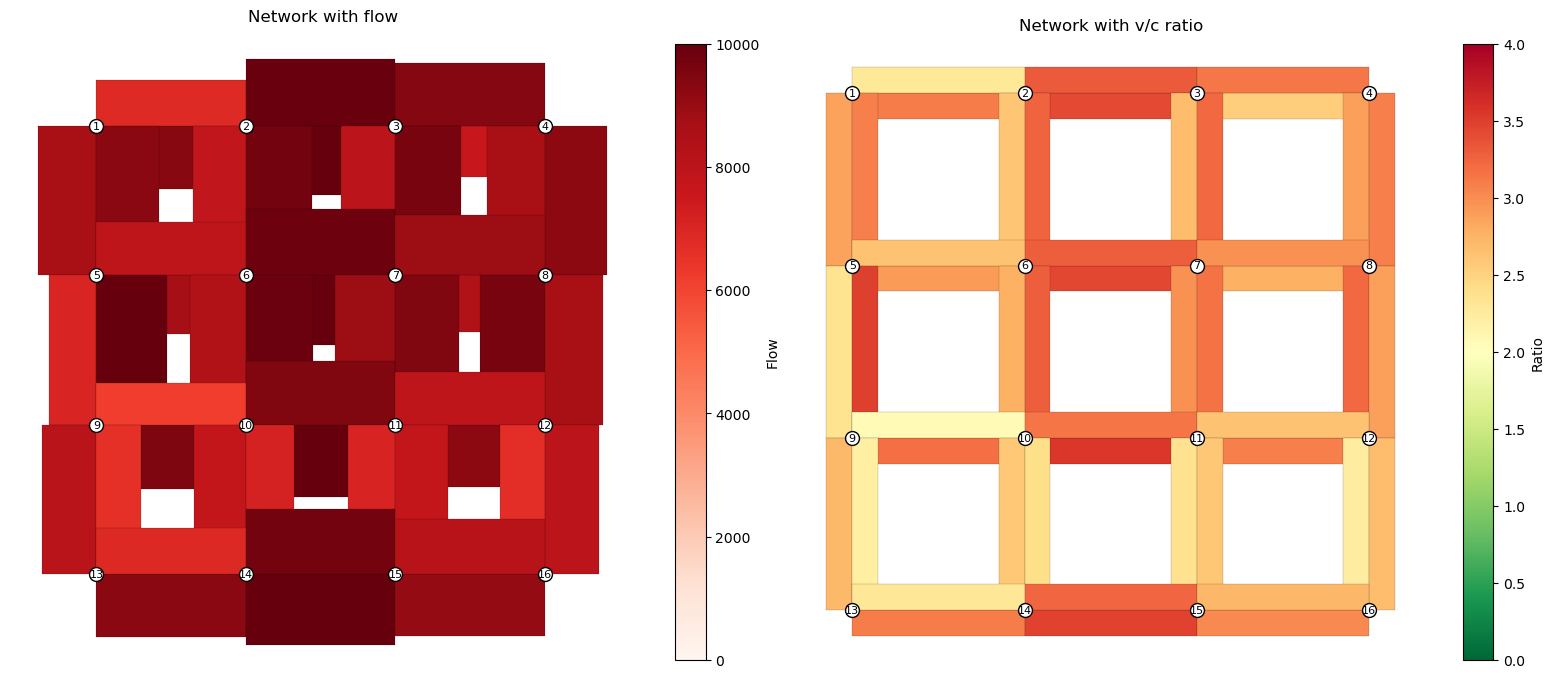

DUE completed in 0.92s | RGAP: 0.000093 | TTT: 156563624738


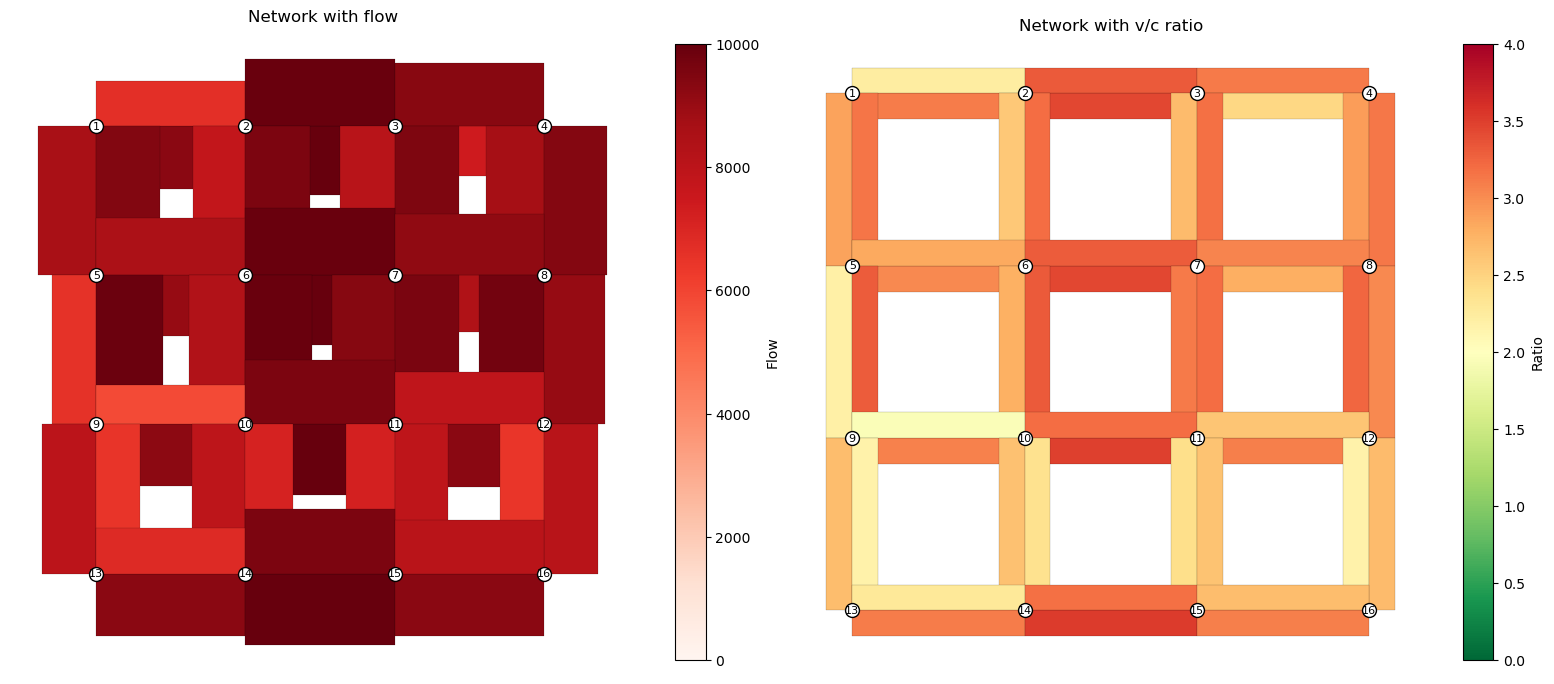

DUE completed in 0.96s | RGAP: 0.000094 | TTT: 156563671666


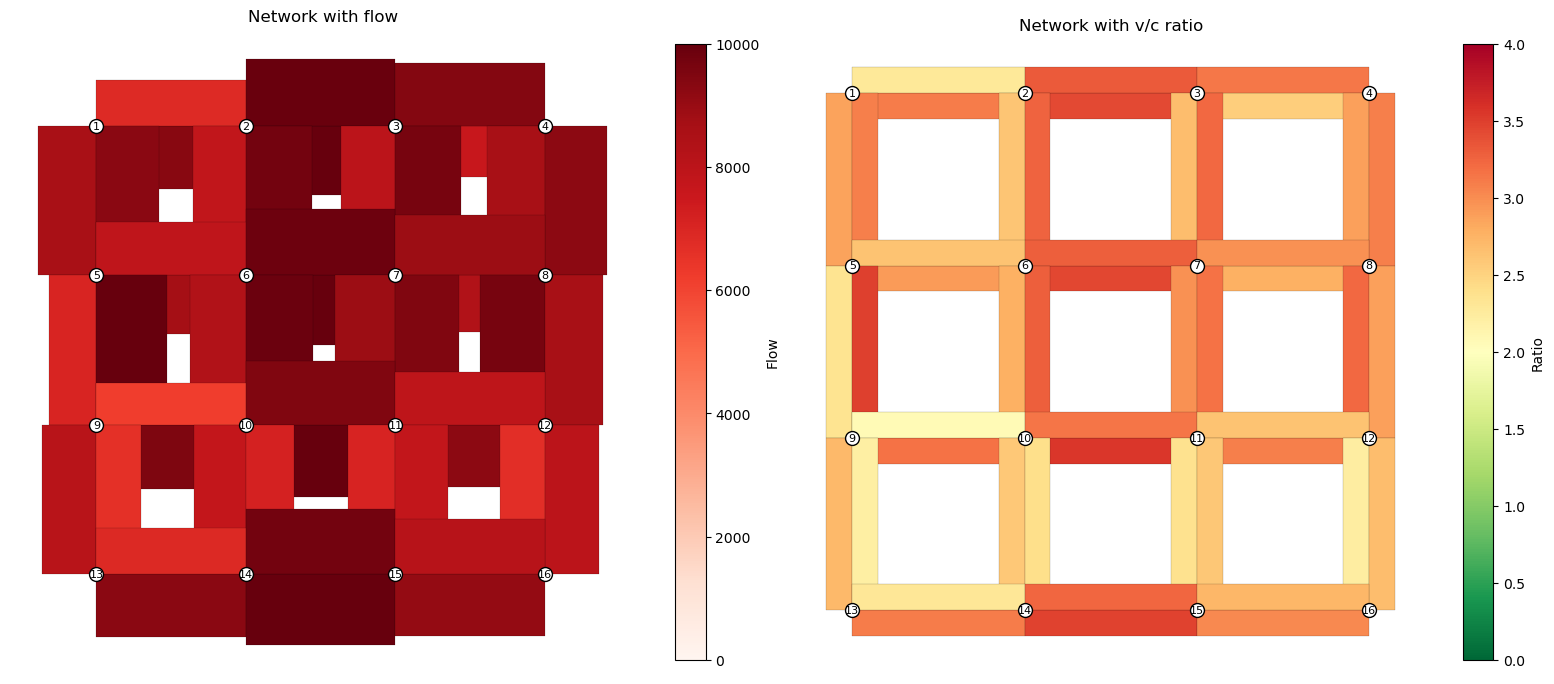

DUE completed in 0.81s | RGAP: 0.000095 | TTT: 156566677222


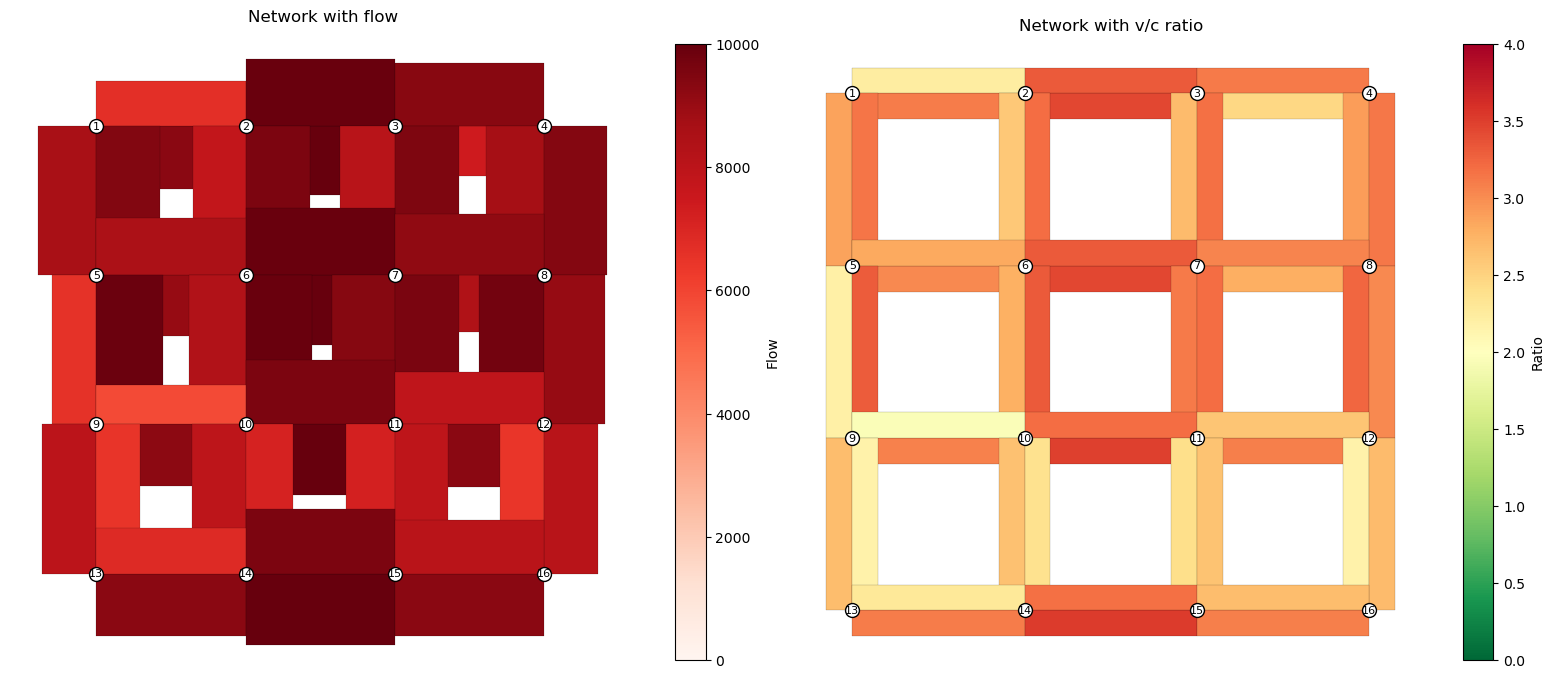

DUE completed in 1.16s | RGAP: 0.000099 | TTT: 156565977574


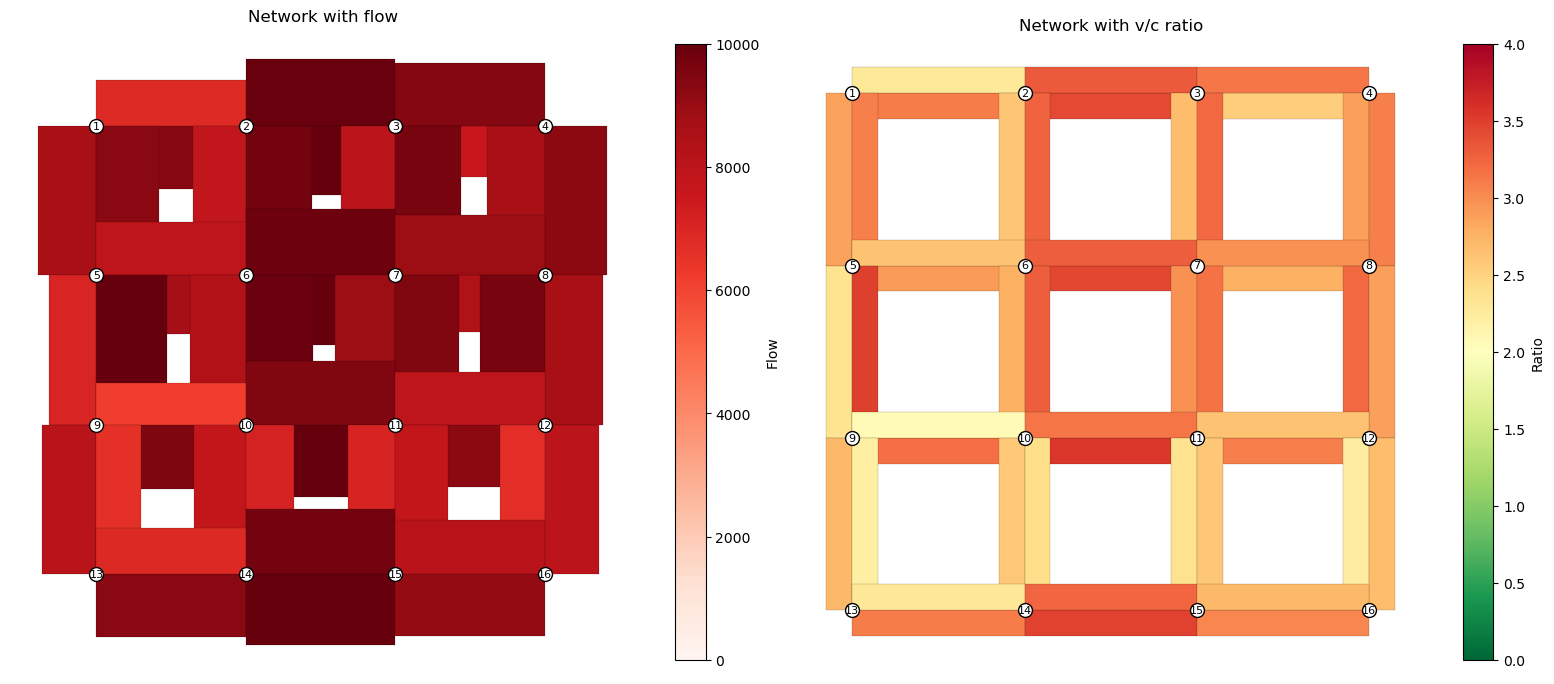

DUE completed in 1.16s | RGAP: 0.000088 | TTT: 156563894640


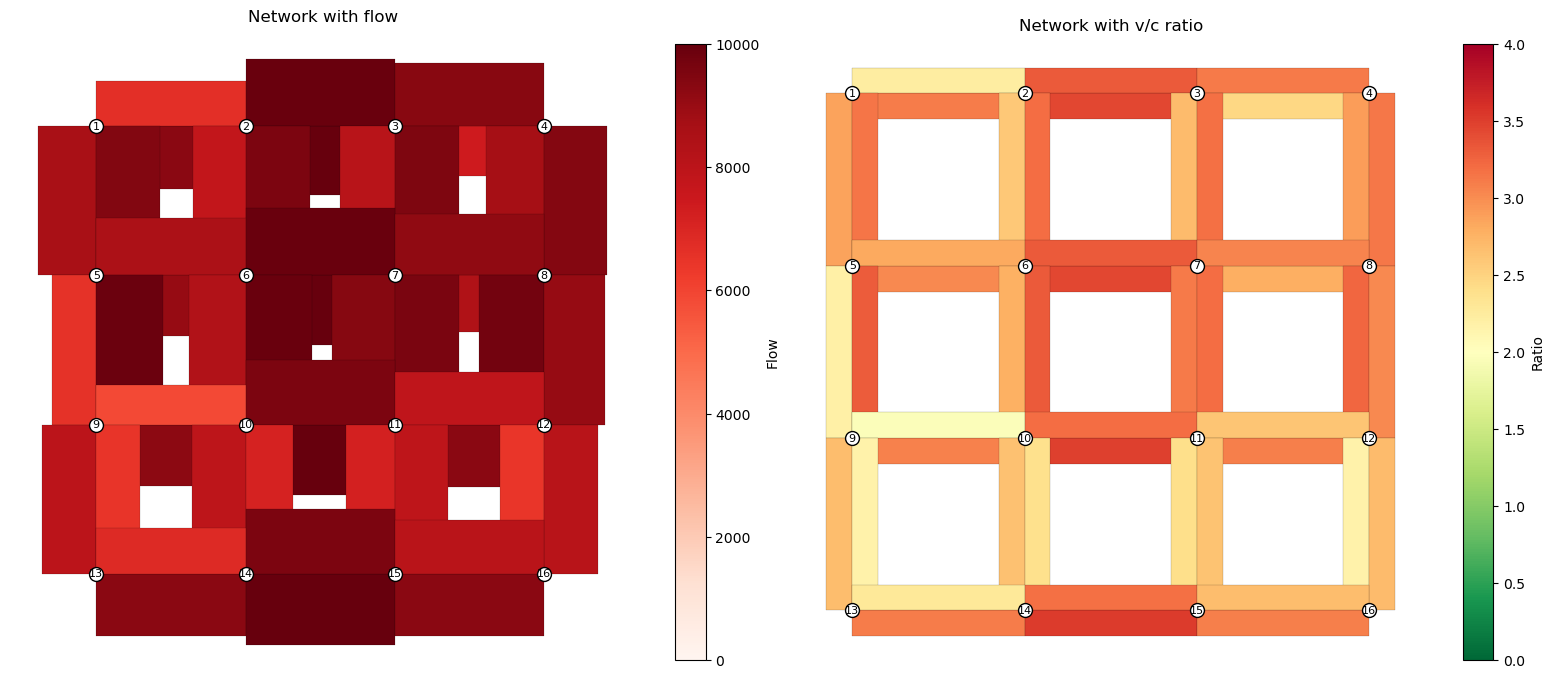

DUE completed in 0.95s | RGAP: 0.000082 | TTT: 156563959520


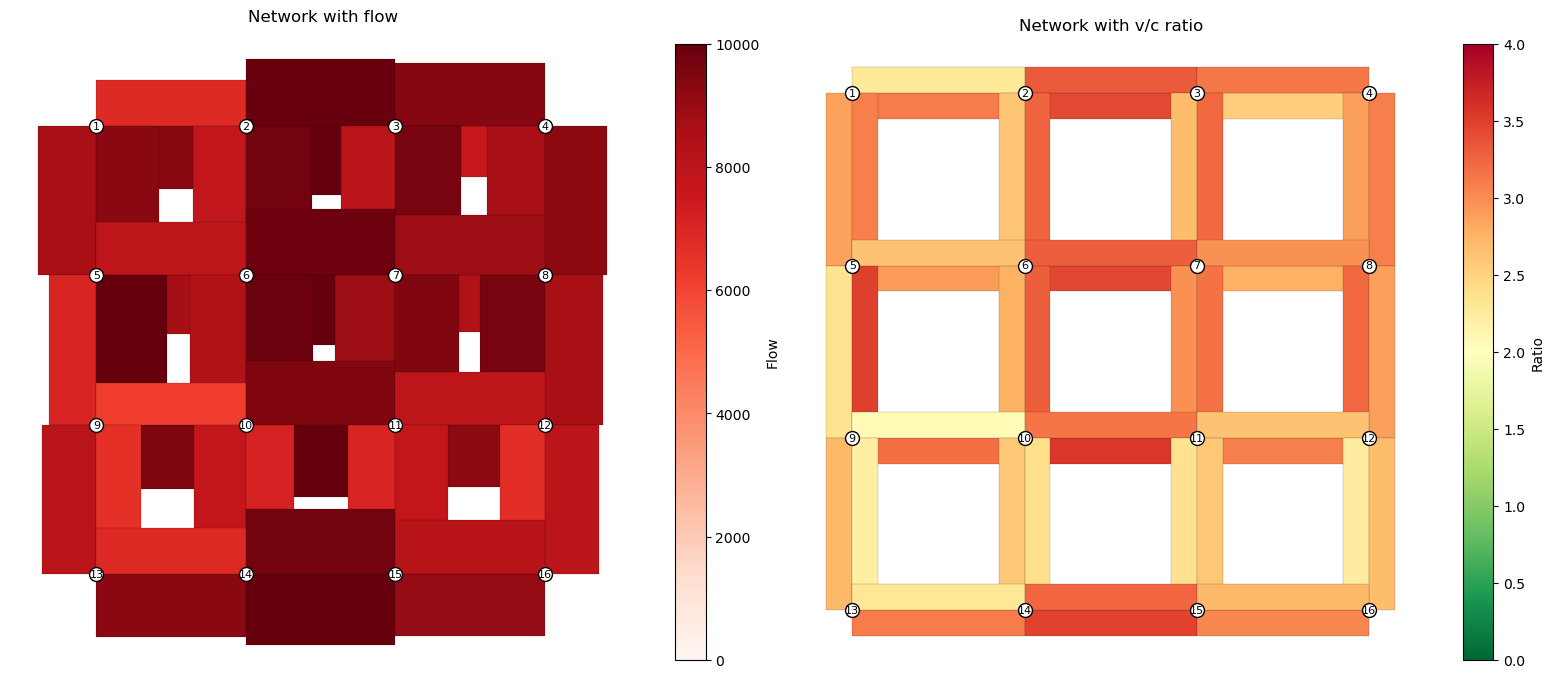

DUE completed in 1.21s | RGAP: 0.000099 | TTT: 156564007445


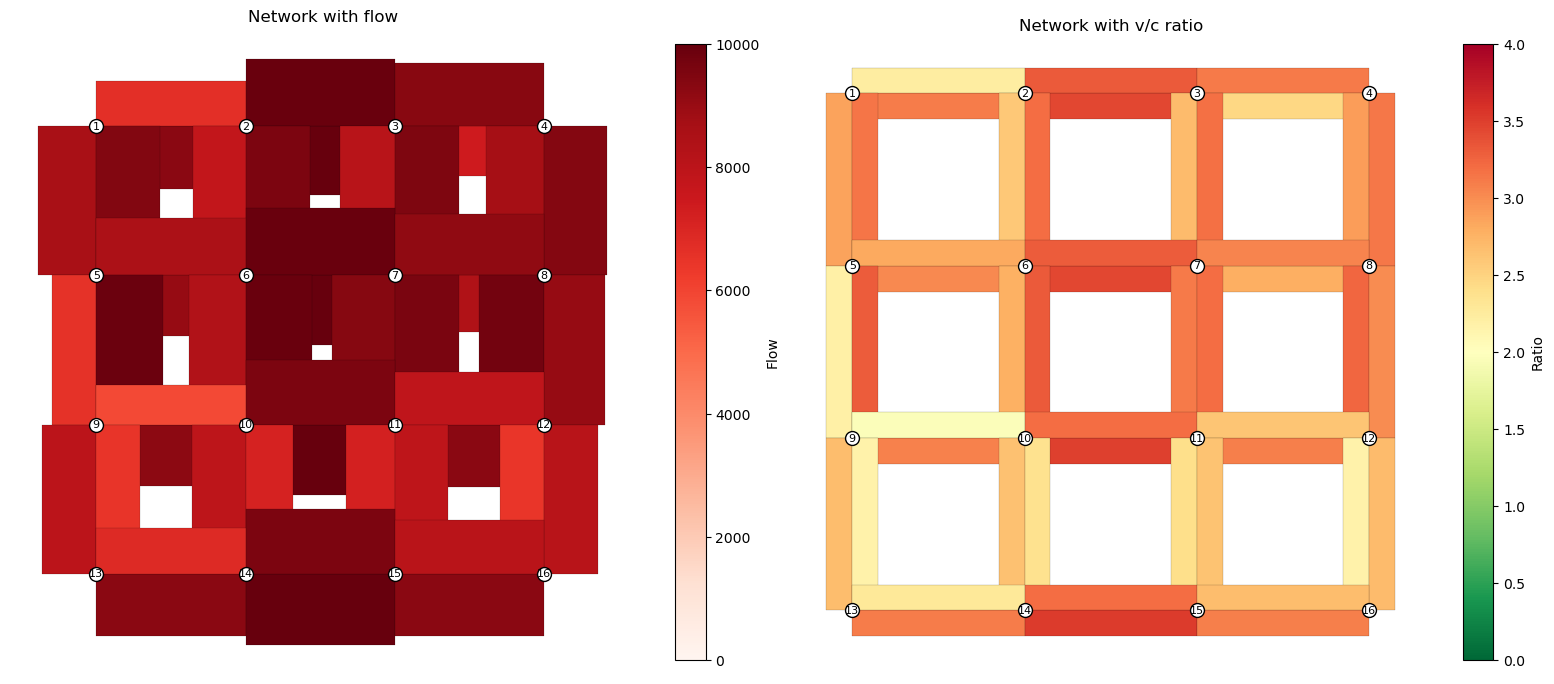

DUE completed in 0.88s | RGAP: 0.000098 | TTT: 156568889868


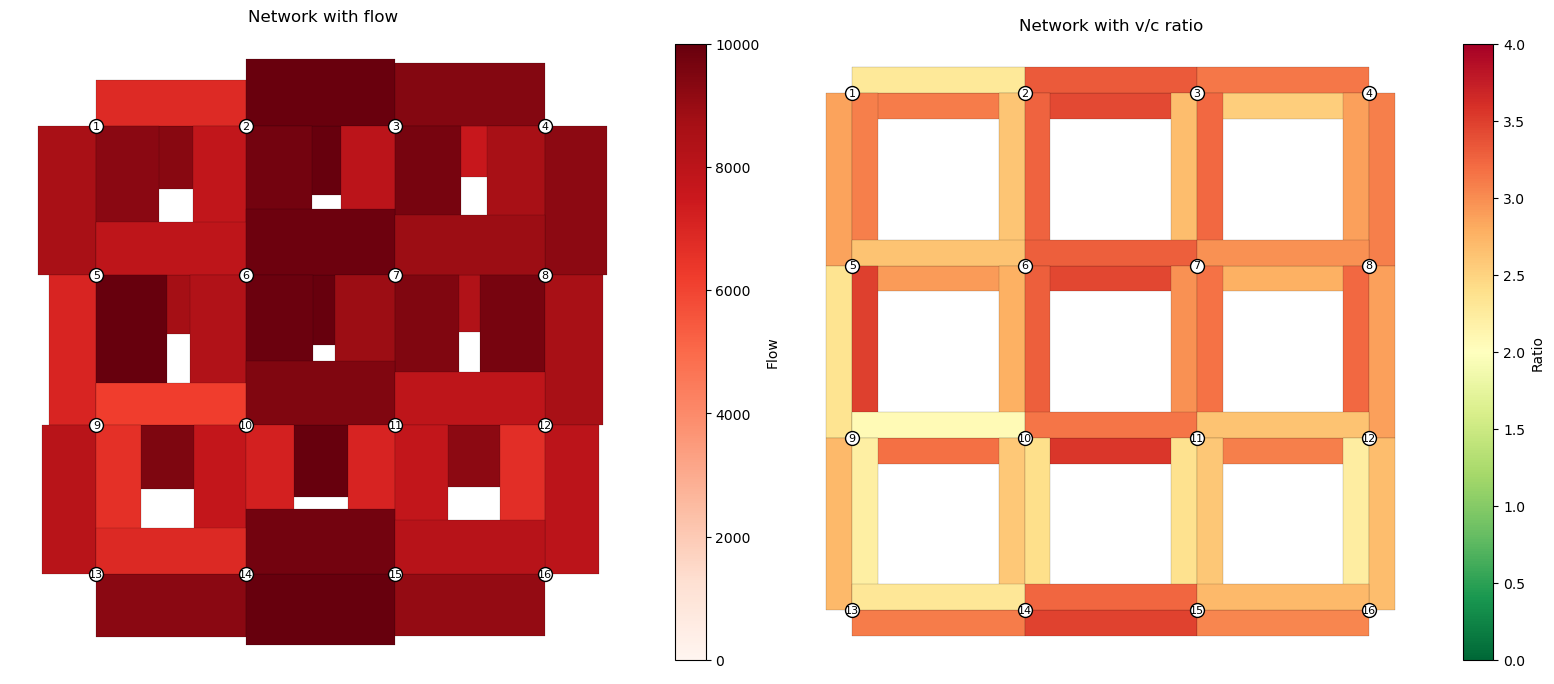

DUE completed in 1.15s | RGAP: 0.000082 | TTT: 156569737919


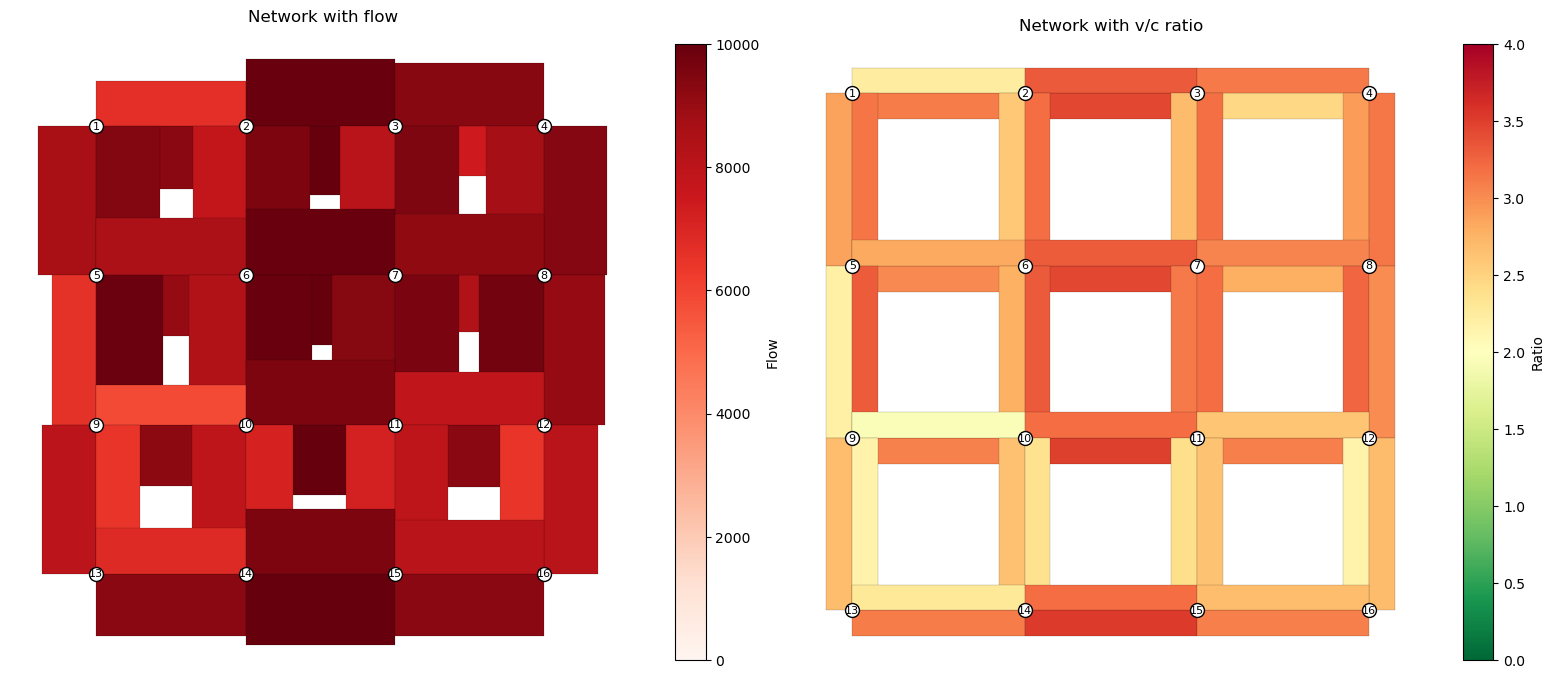

DUE completed in 1.49s | RGAP: 0.000091 | TTT: 156567276122


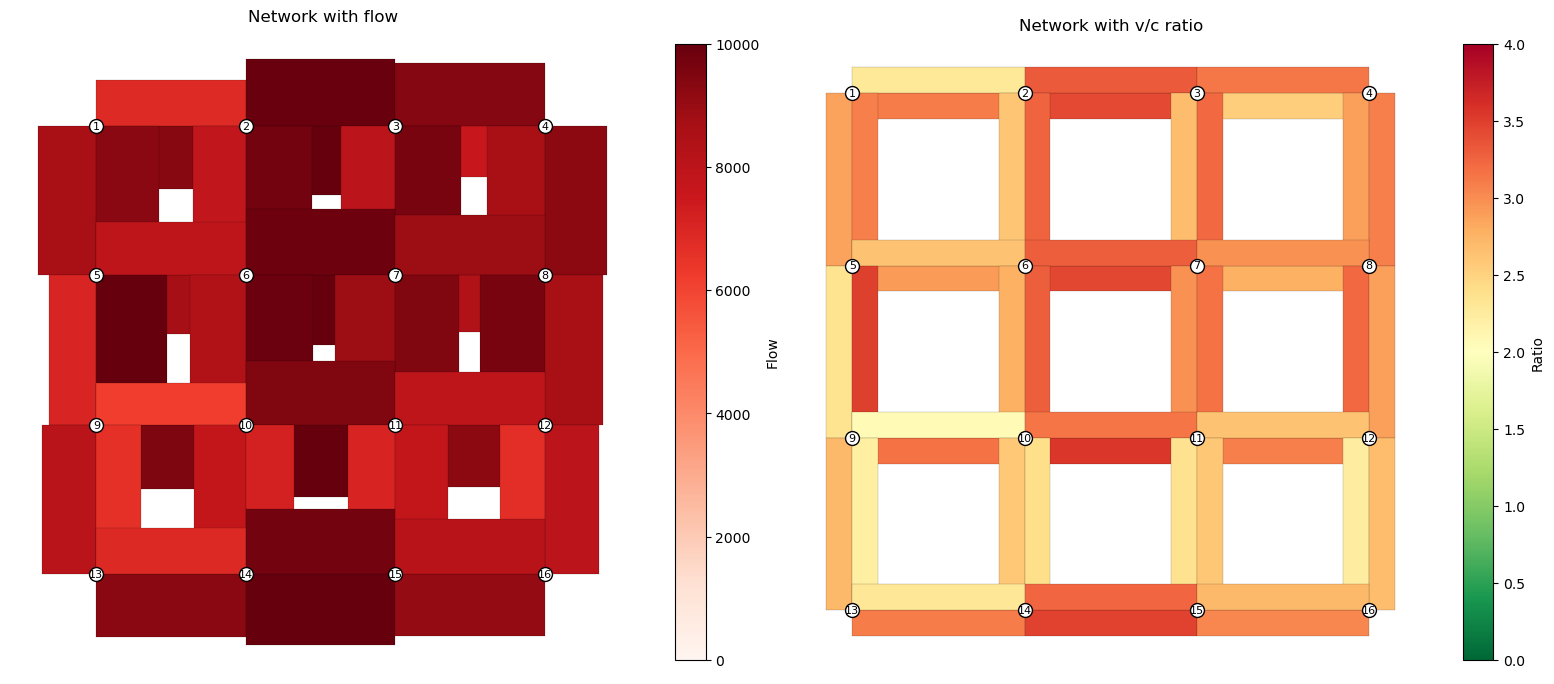

DUE completed in 1.10s | RGAP: 0.000076 | TTT: 156565536247


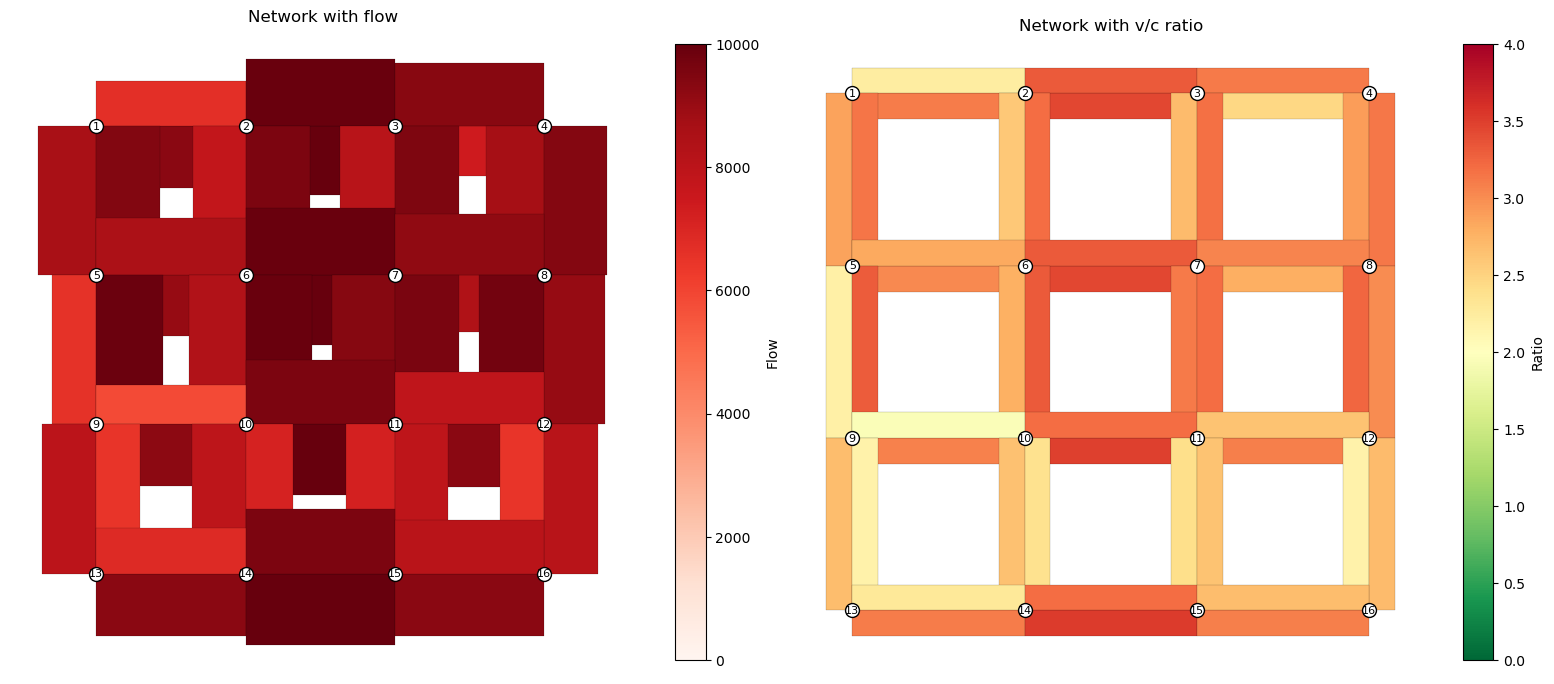

DUE completed in 1.60s | RGAP: 0.000062 | TTT: 156564198941


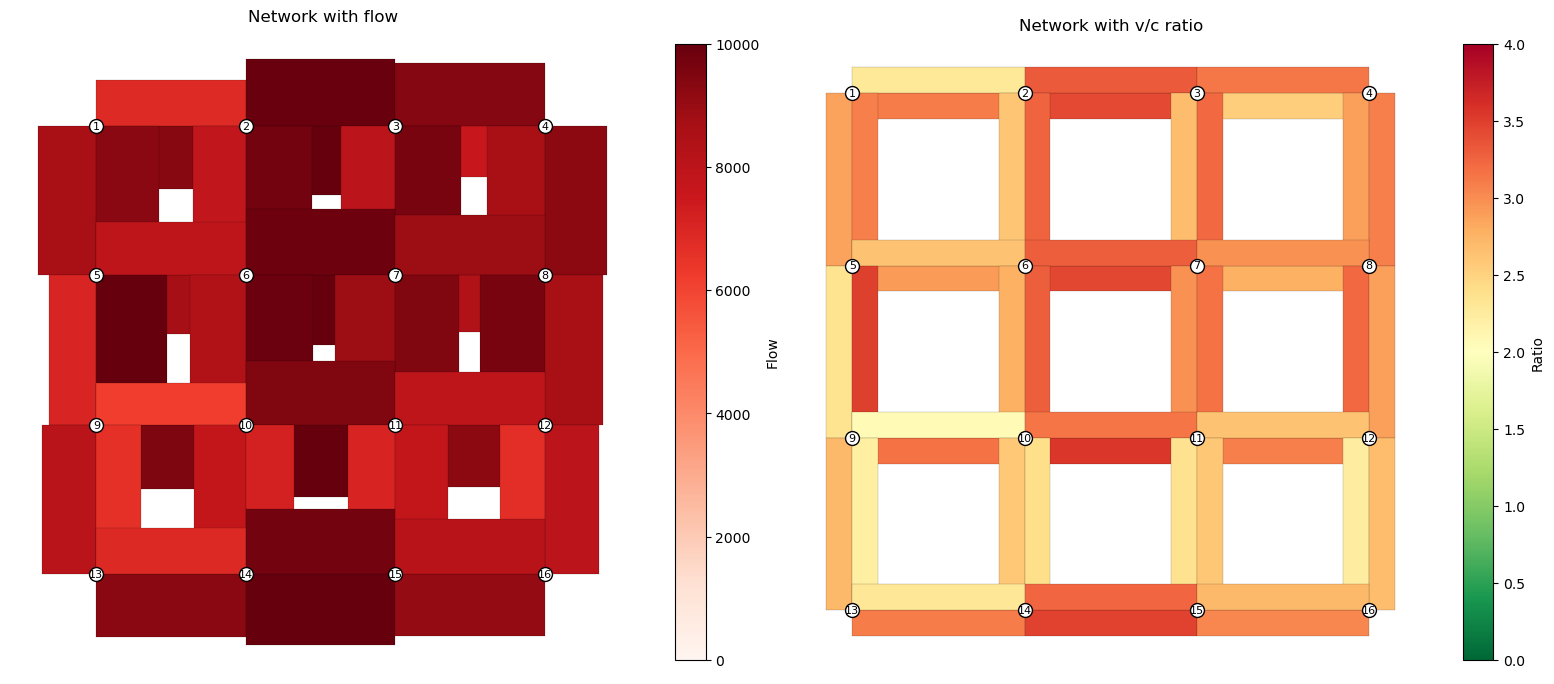

DUE completed in 0.96s | RGAP: 0.000090 | TTT: 156565294454


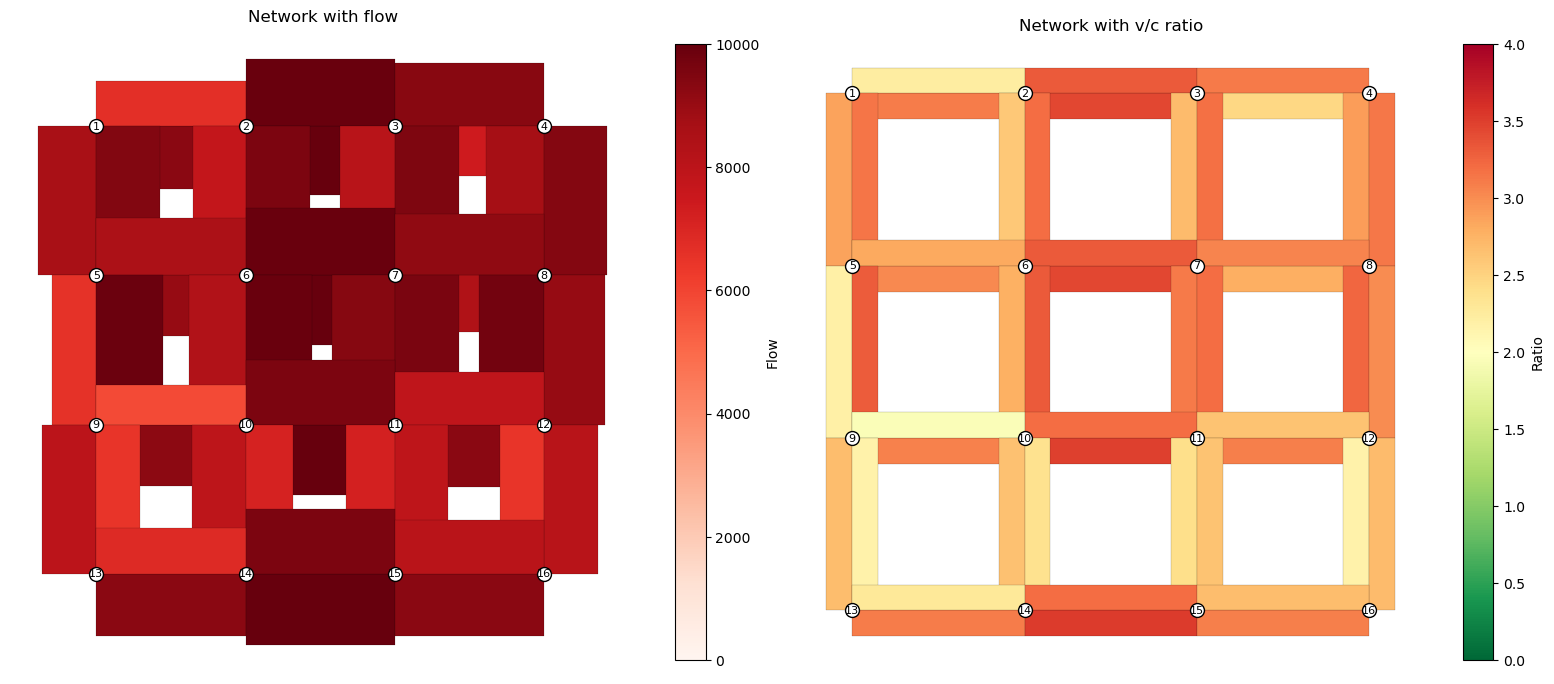

DUE completed in 1.50s | RGAP: 0.000069 | TTT: 156565108822


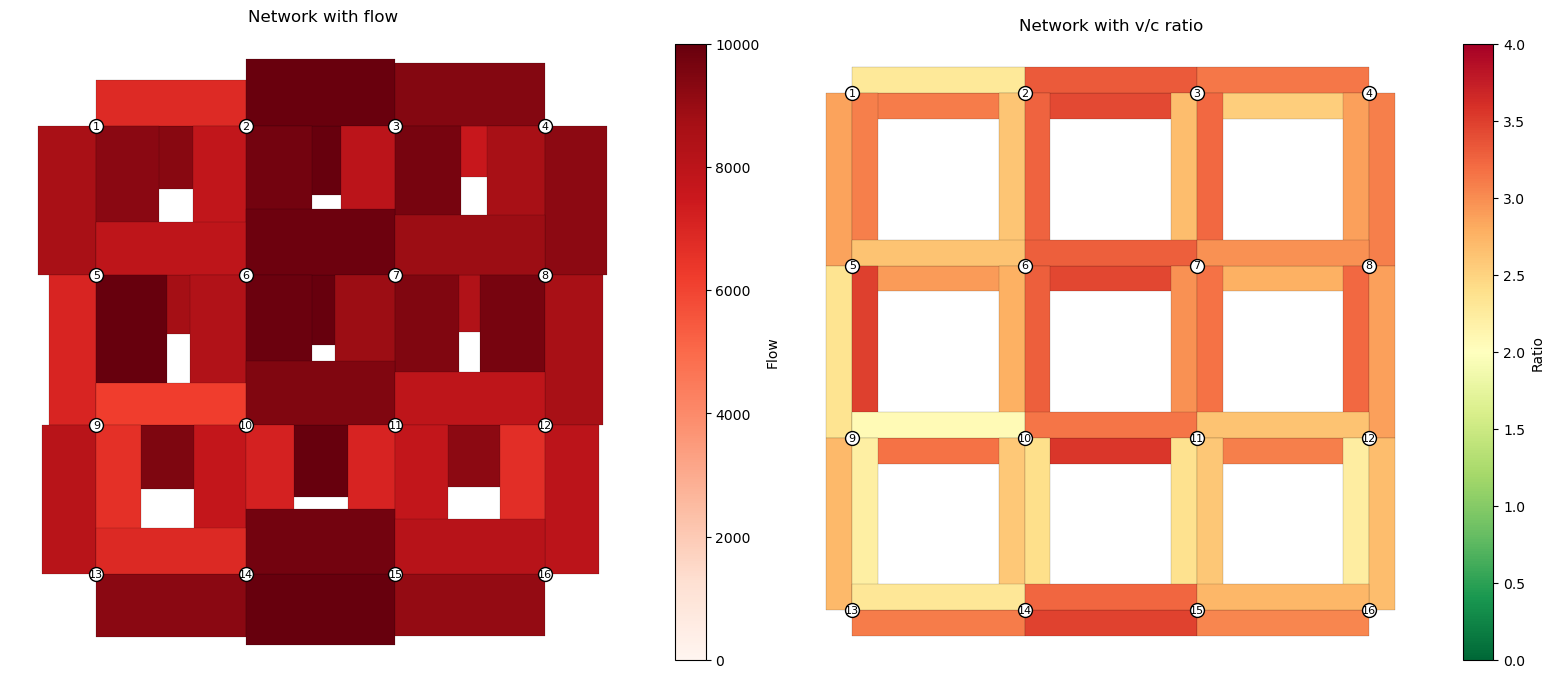

DUE completed in 0.89s | RGAP: 0.000081 | TTT: 156564342815


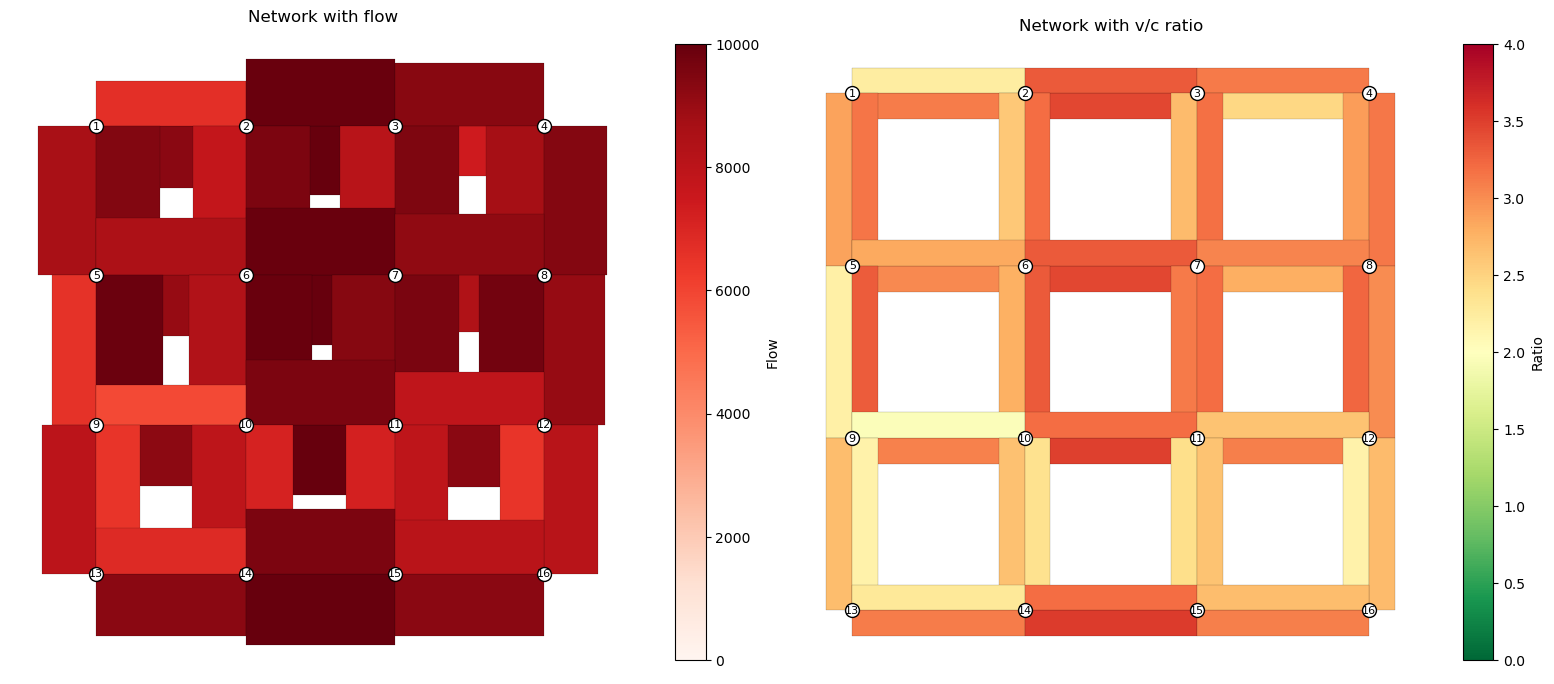

DUE completed in 1.46s | RGAP: 0.000090 | TTT: 156564433780


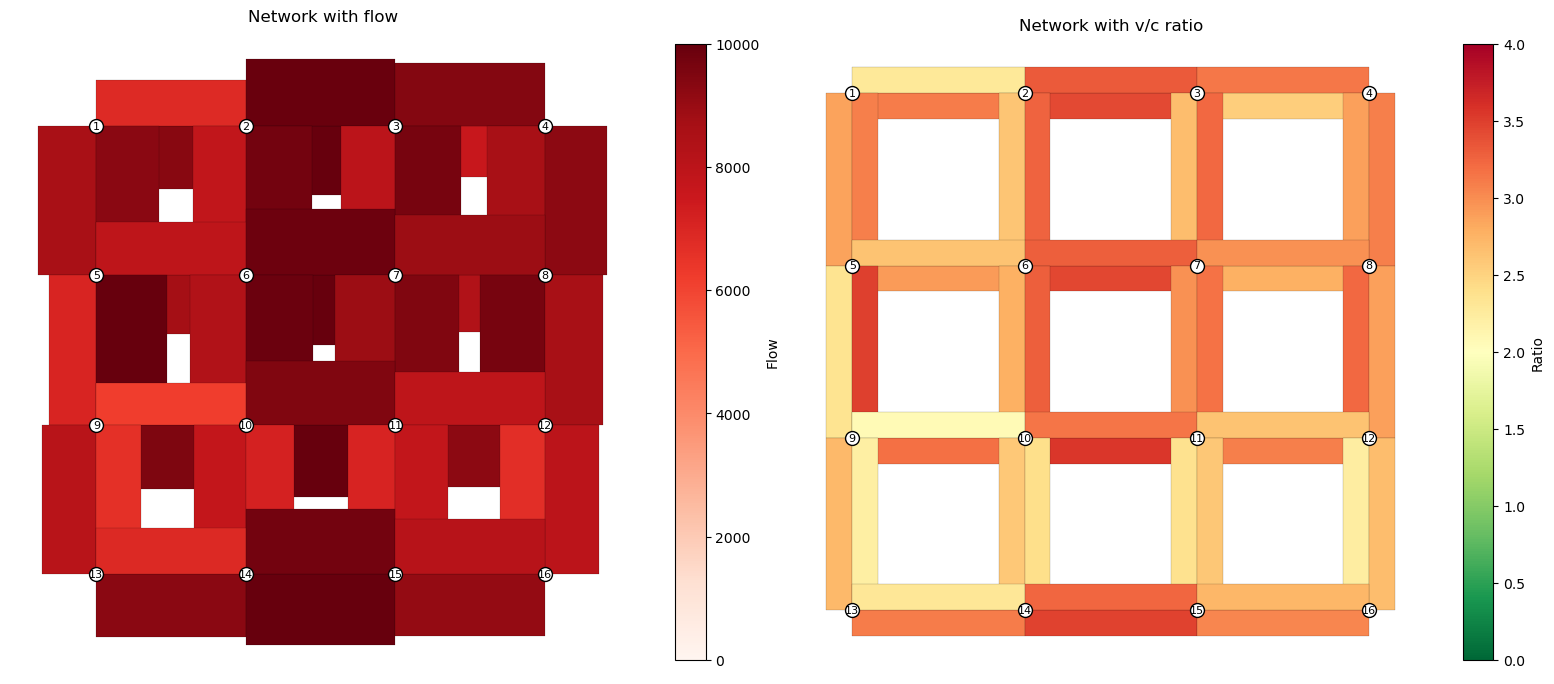

DUE completed in 1.07s | RGAP: 0.000096 | TTT: 156564261496


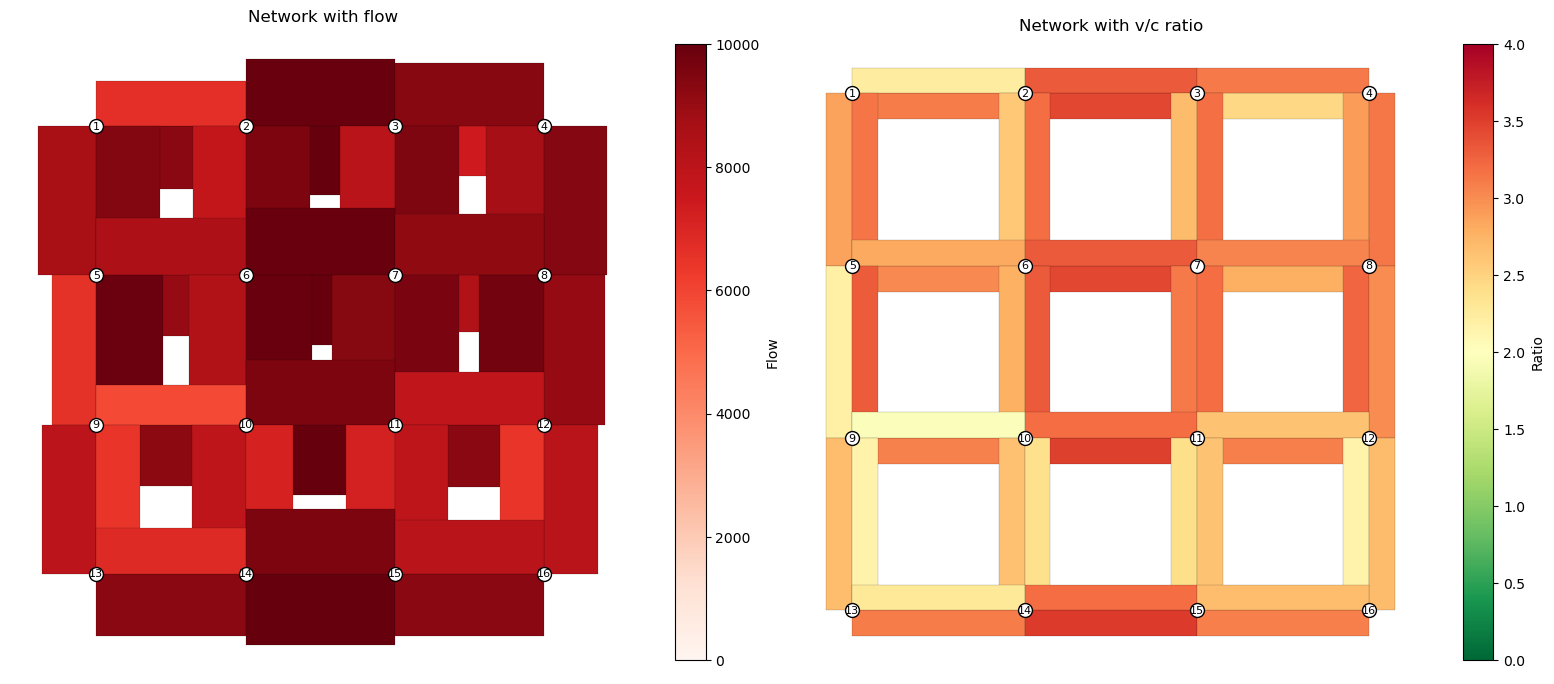

DUE completed in 0.93s | RGAP: 0.000065 | TTT: 156564431909


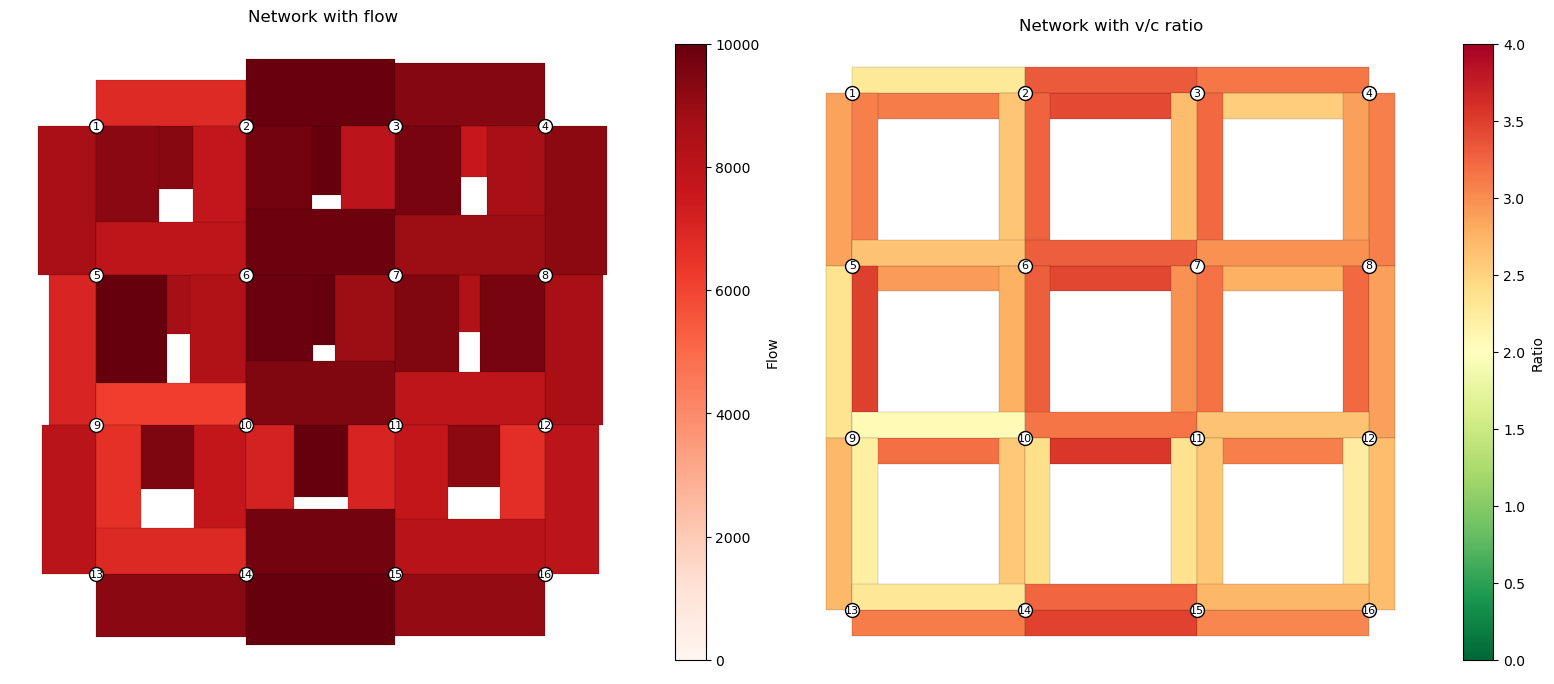

DUE completed in 1.06s | RGAP: 0.000080 | TTT: 156564253347


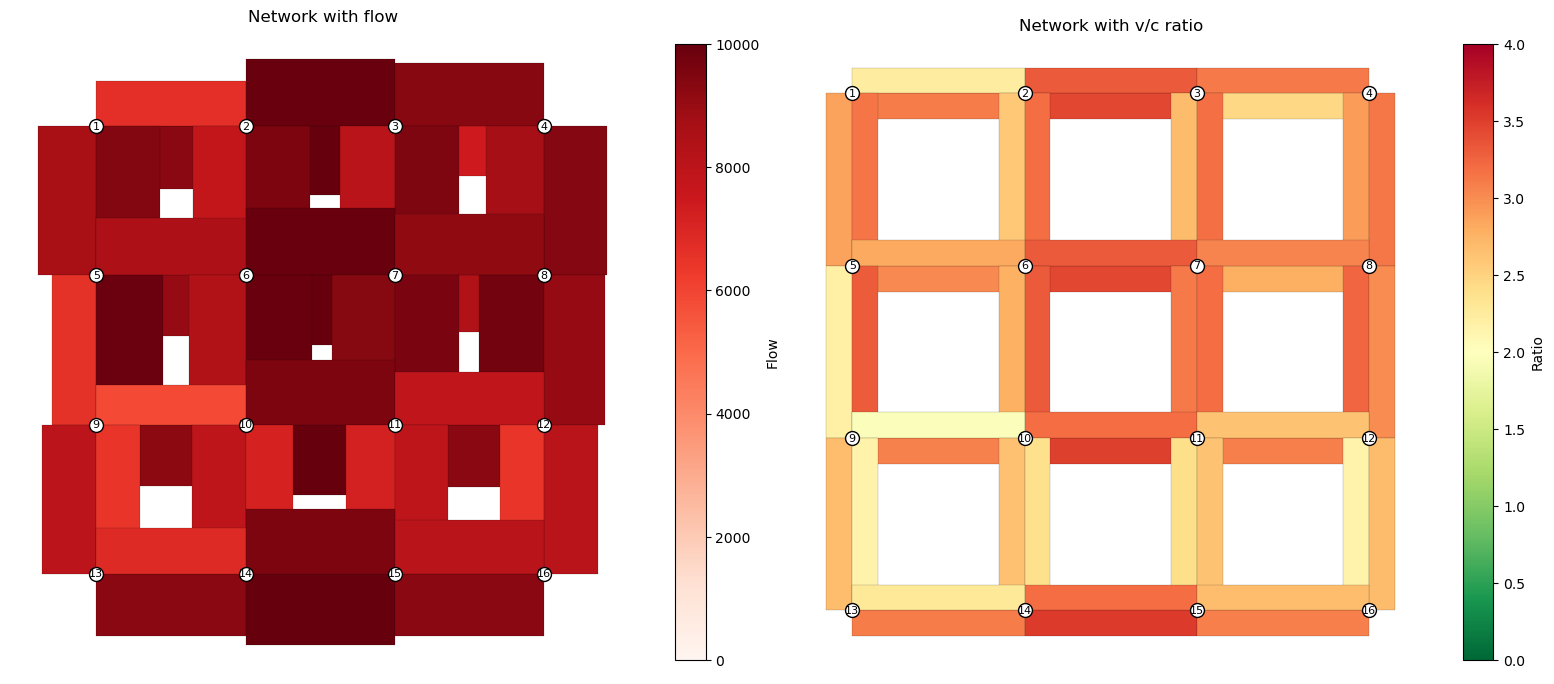

DUE completed in 0.95s | RGAP: 0.000086 | TTT: 156564310031


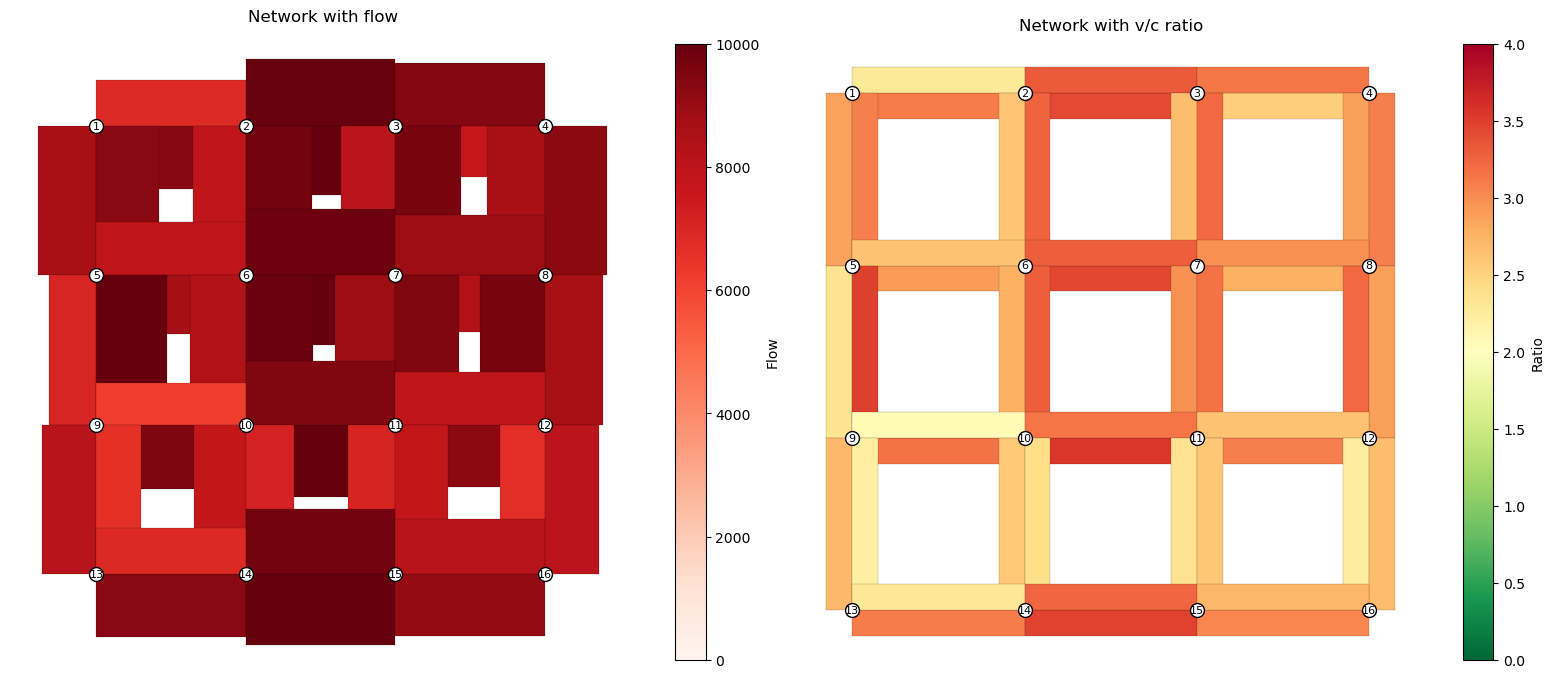

DUE completed in 1.39s | RGAP: 0.000076 | TTT: 156565432119


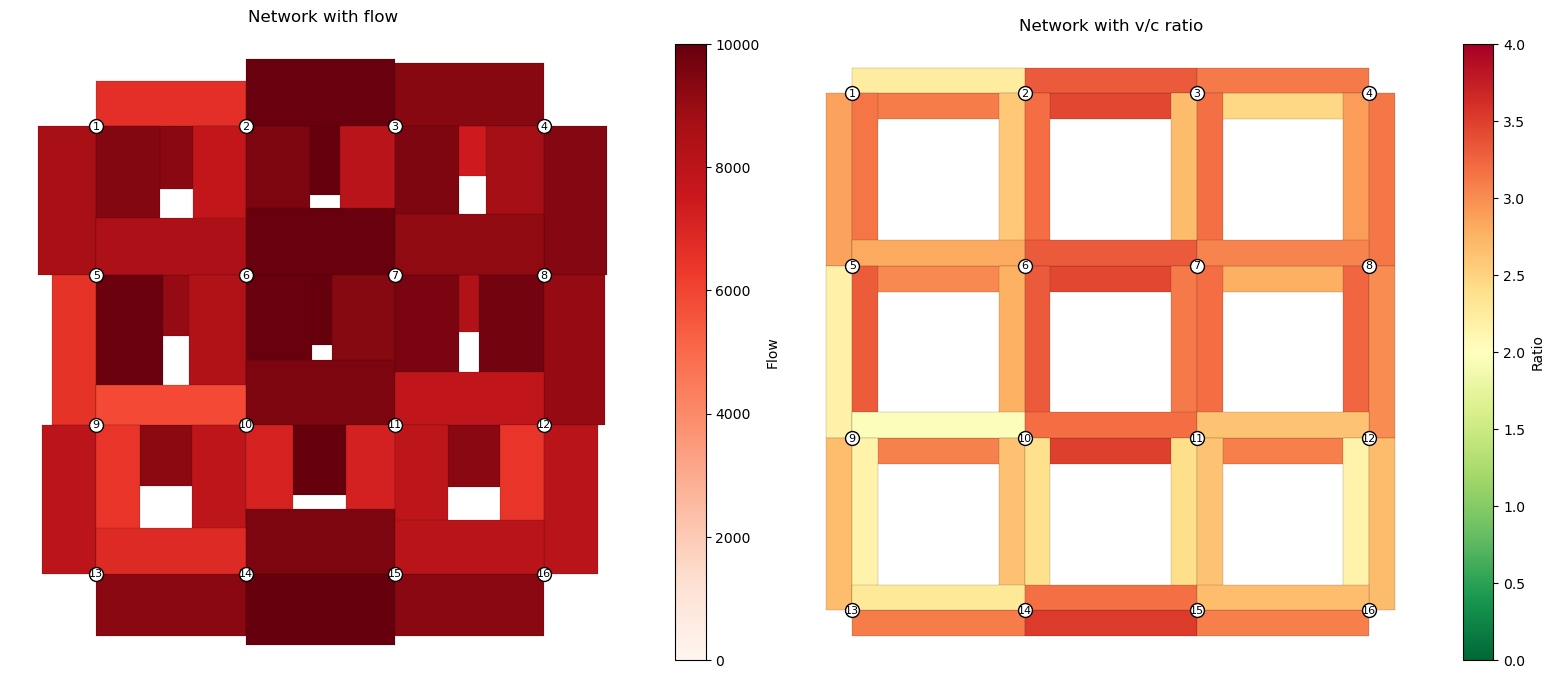

DUE completed in 0.93s | RGAP: 0.000099 | TTT: 156565192276


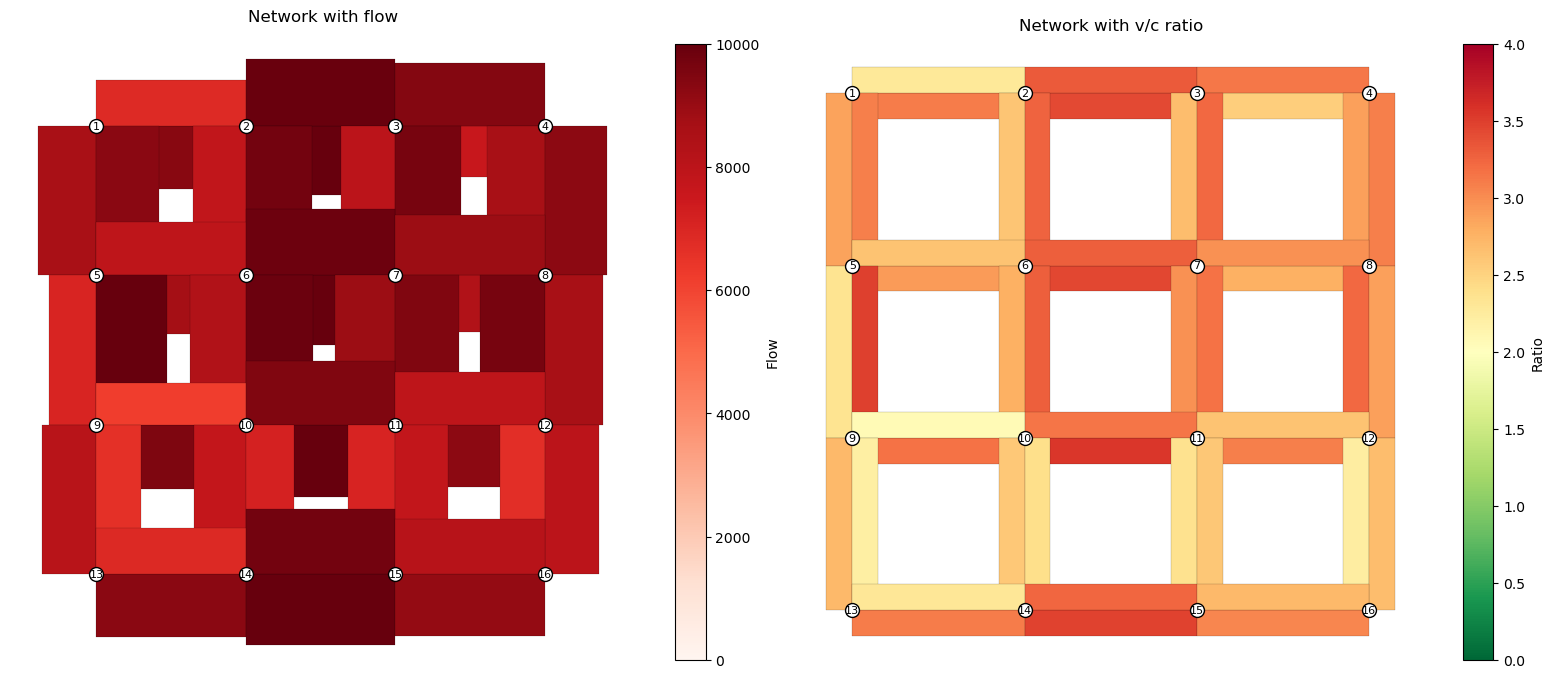

DUE completed in 1.14s | RGAP: 0.000092 | TTT: 156564452470


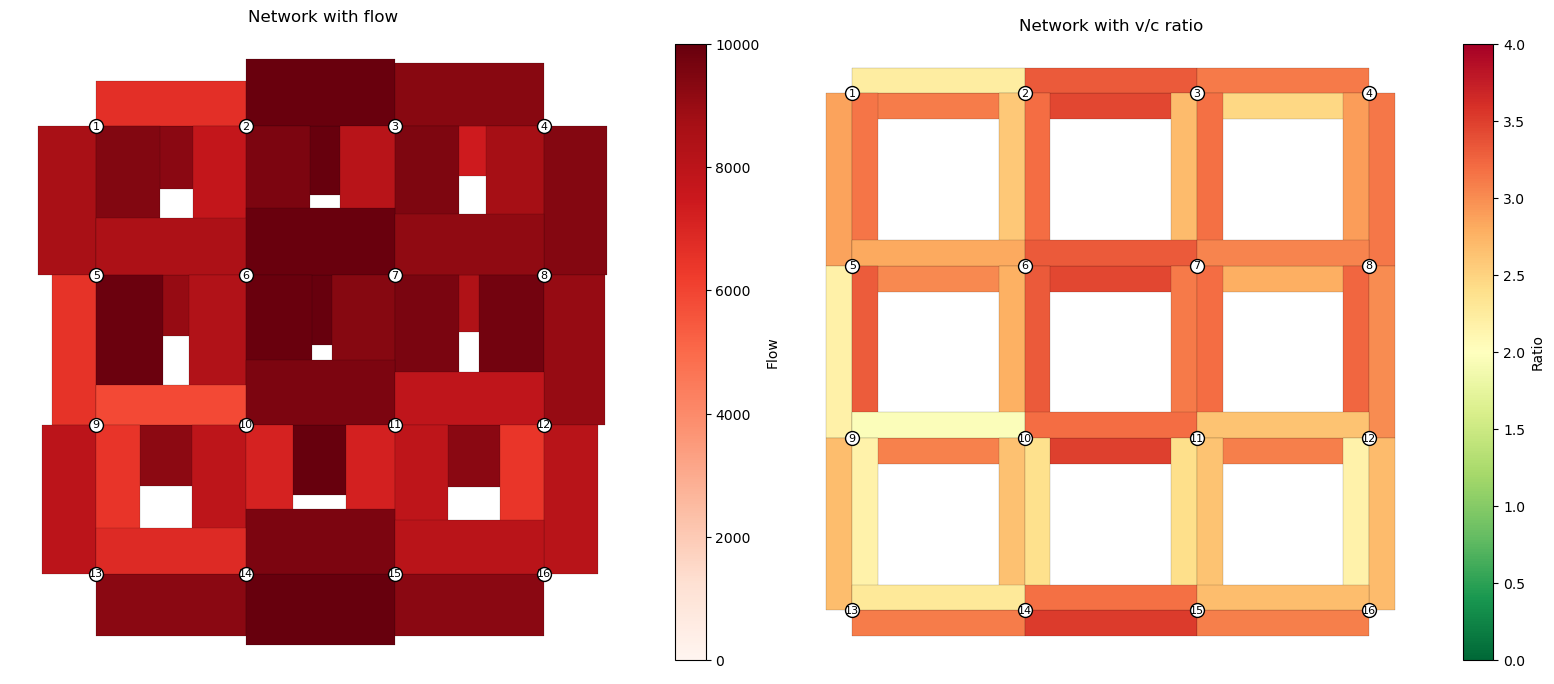

DUE completed in 0.92s | RGAP: 0.000085 | TTT: 156564460410


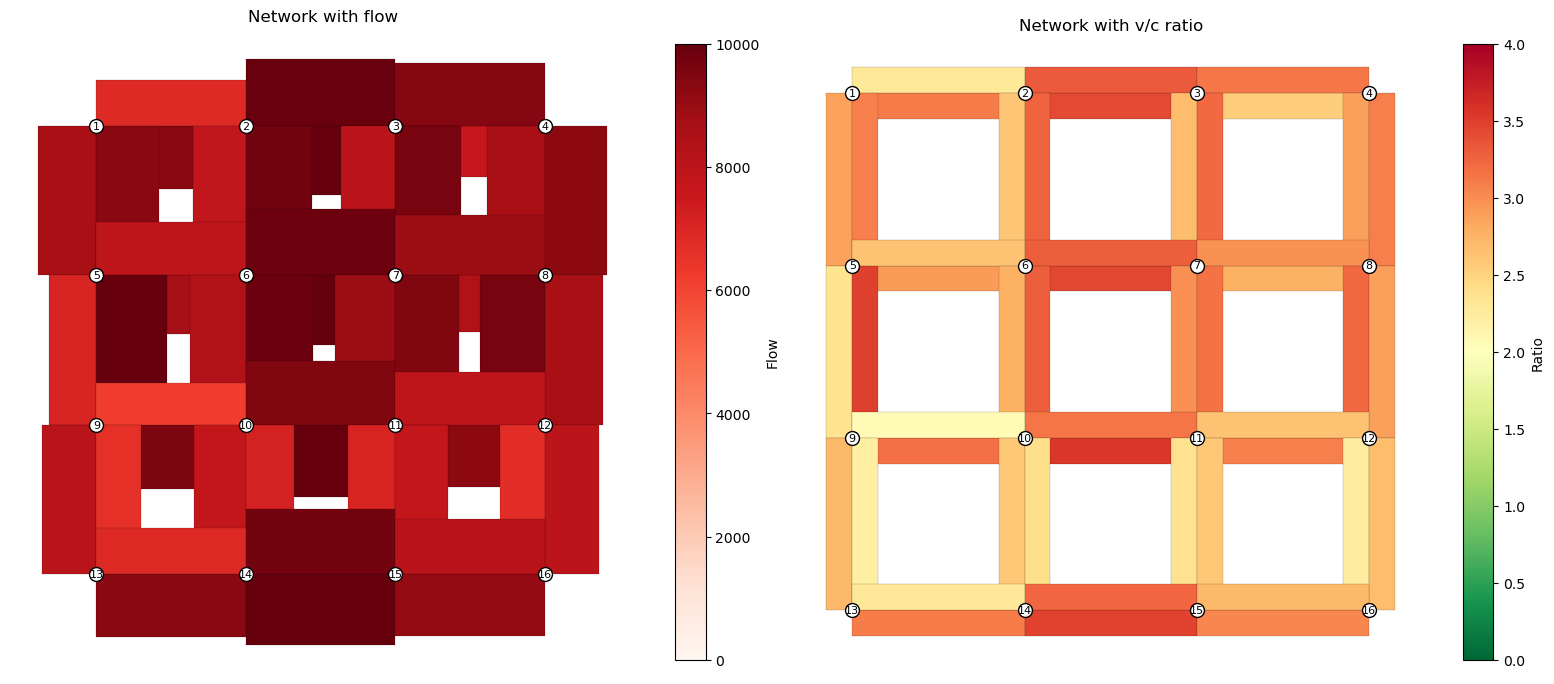

DUE completed in 1.18s | RGAP: 0.000100 | TTT: 156564148460


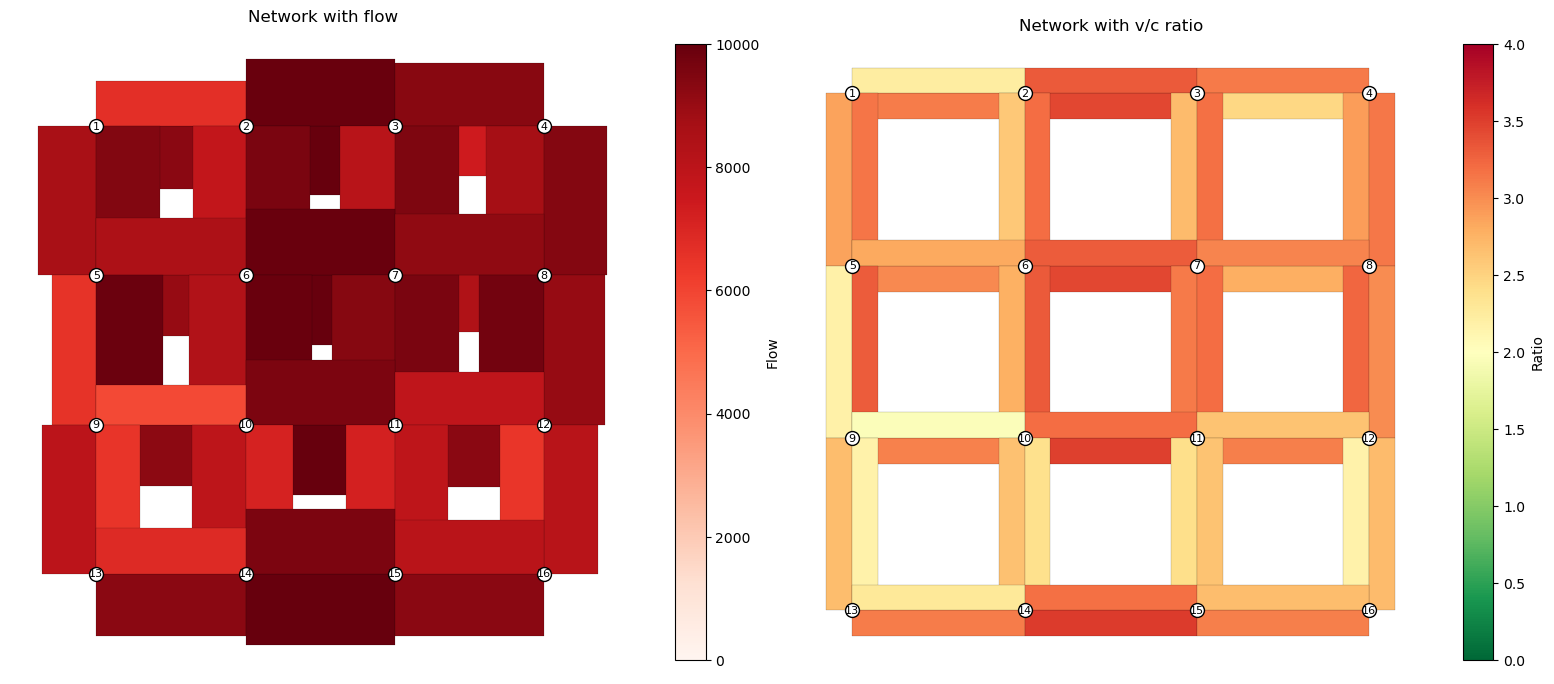

DUE completed in 0.96s | RGAP: 0.000077 | TTT: 156564235148


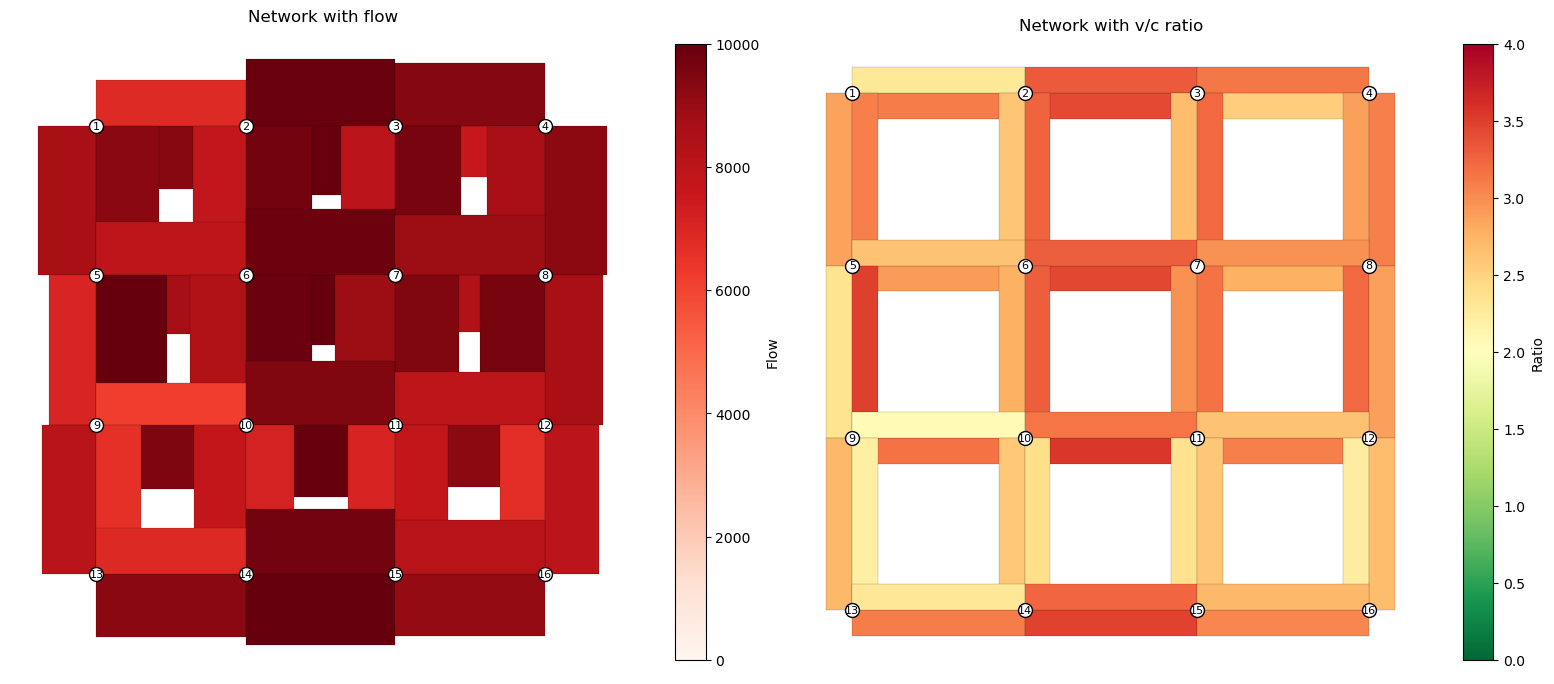

DUE completed in 0.88s | RGAP: 0.000095 | TTT: 156564491470


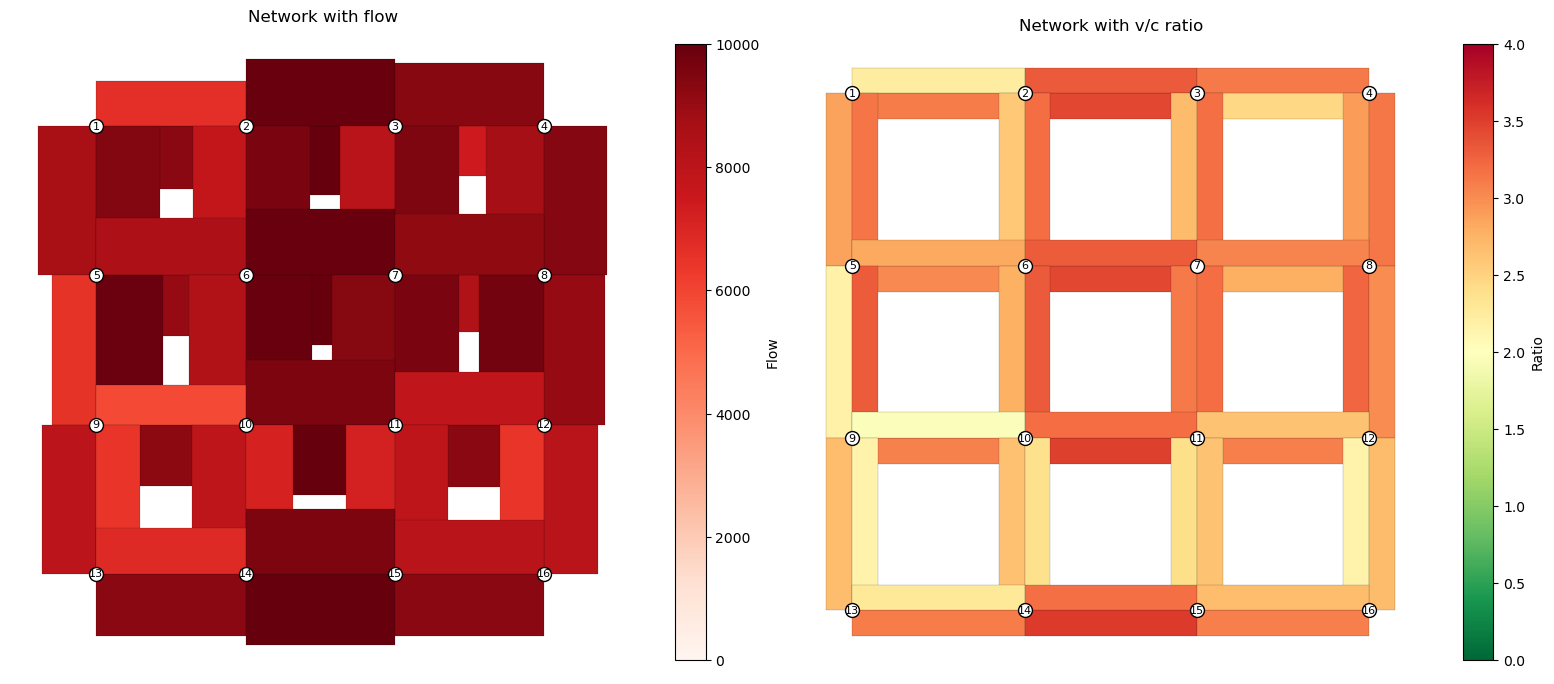

DUE completed in 1.27s | RGAP: 0.000097 | TTT: 156564351260


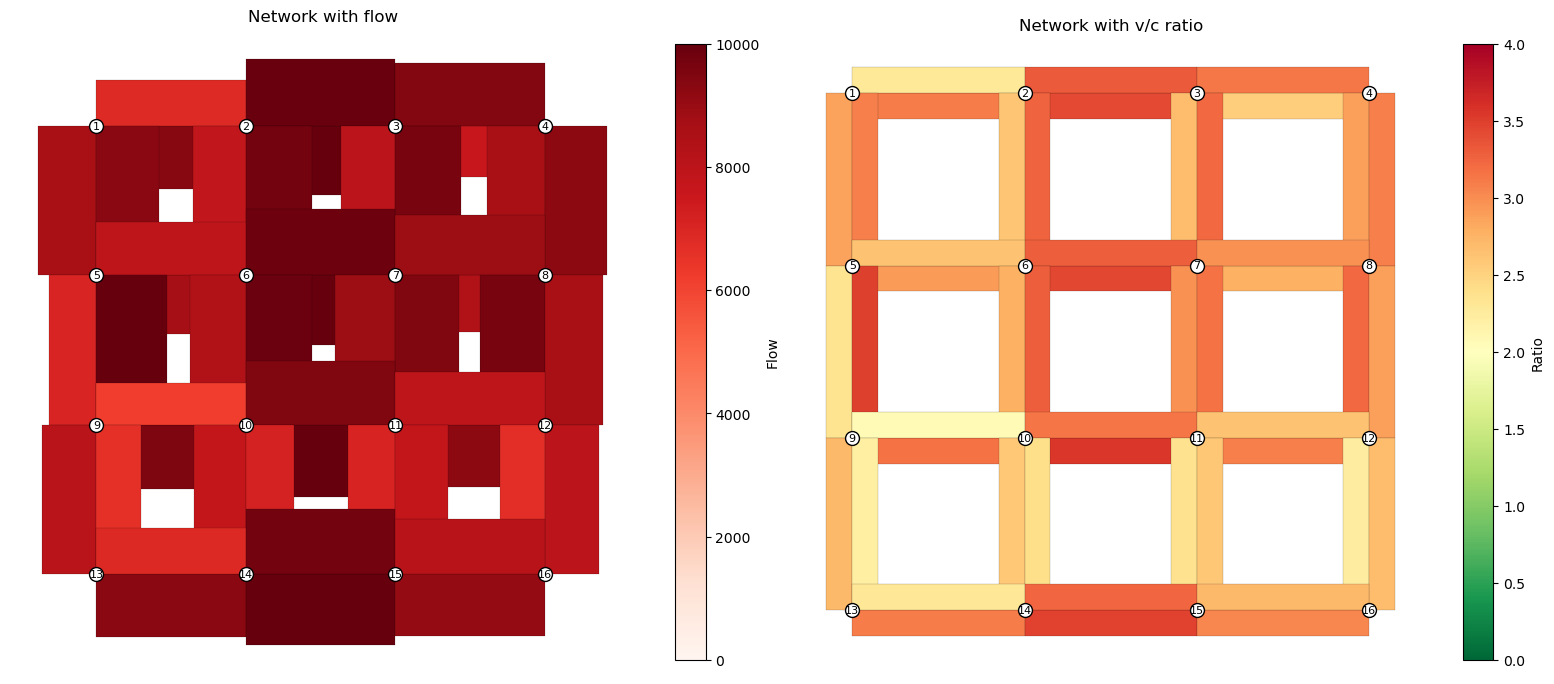

DUE completed in 1.04s | RGAP: 0.000098 | TTT: 156564473849


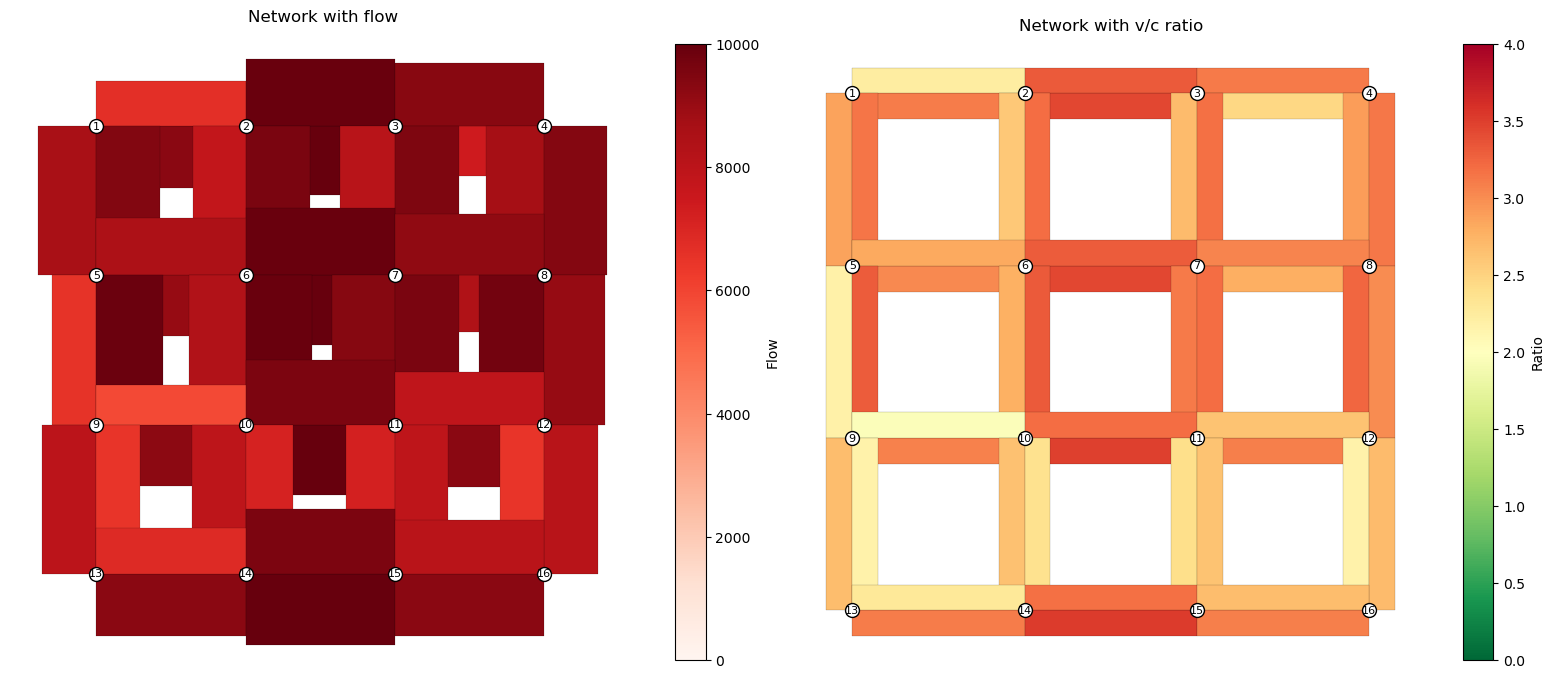

DUE completed in 1.10s | RGAP: 0.000094 | TTT: 156569762584


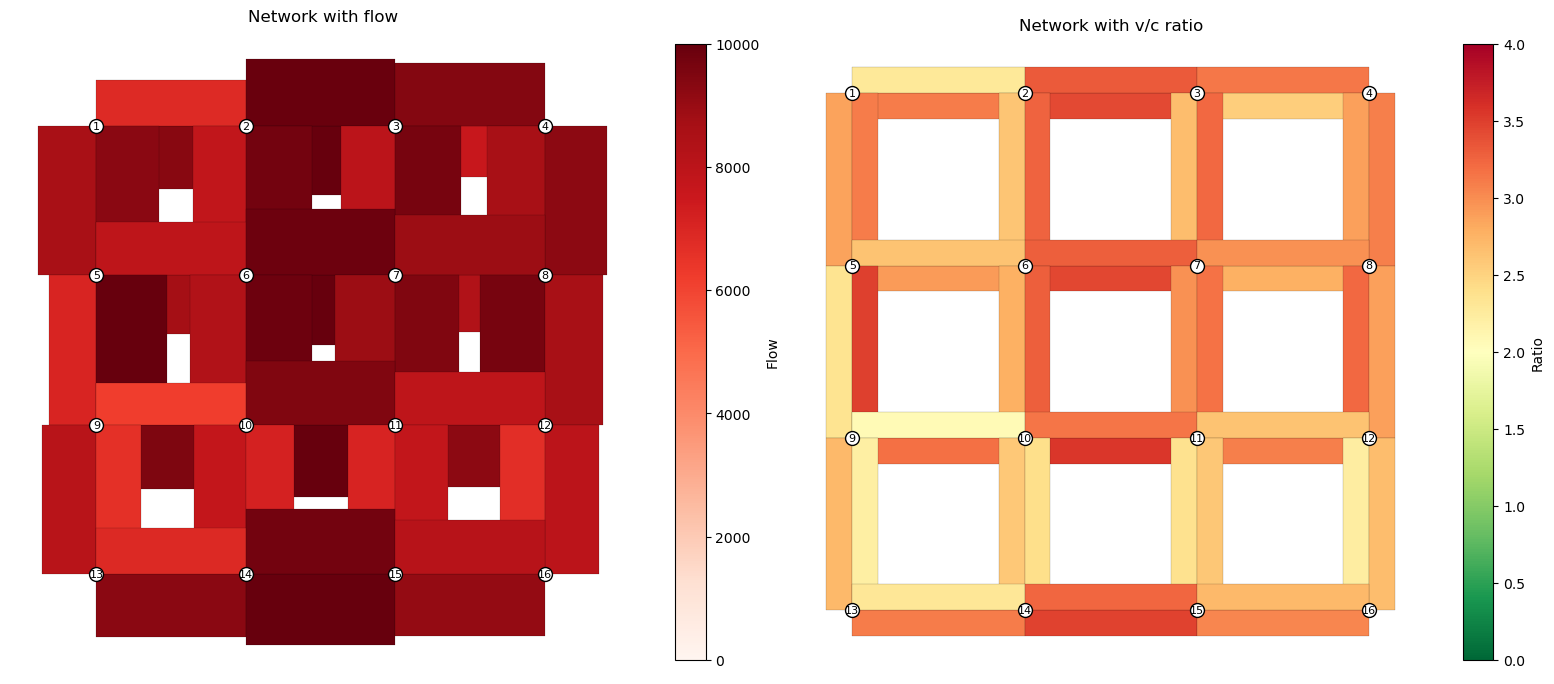

DUE completed in 0.88s | RGAP: 0.000094 | TTT: 156568195441


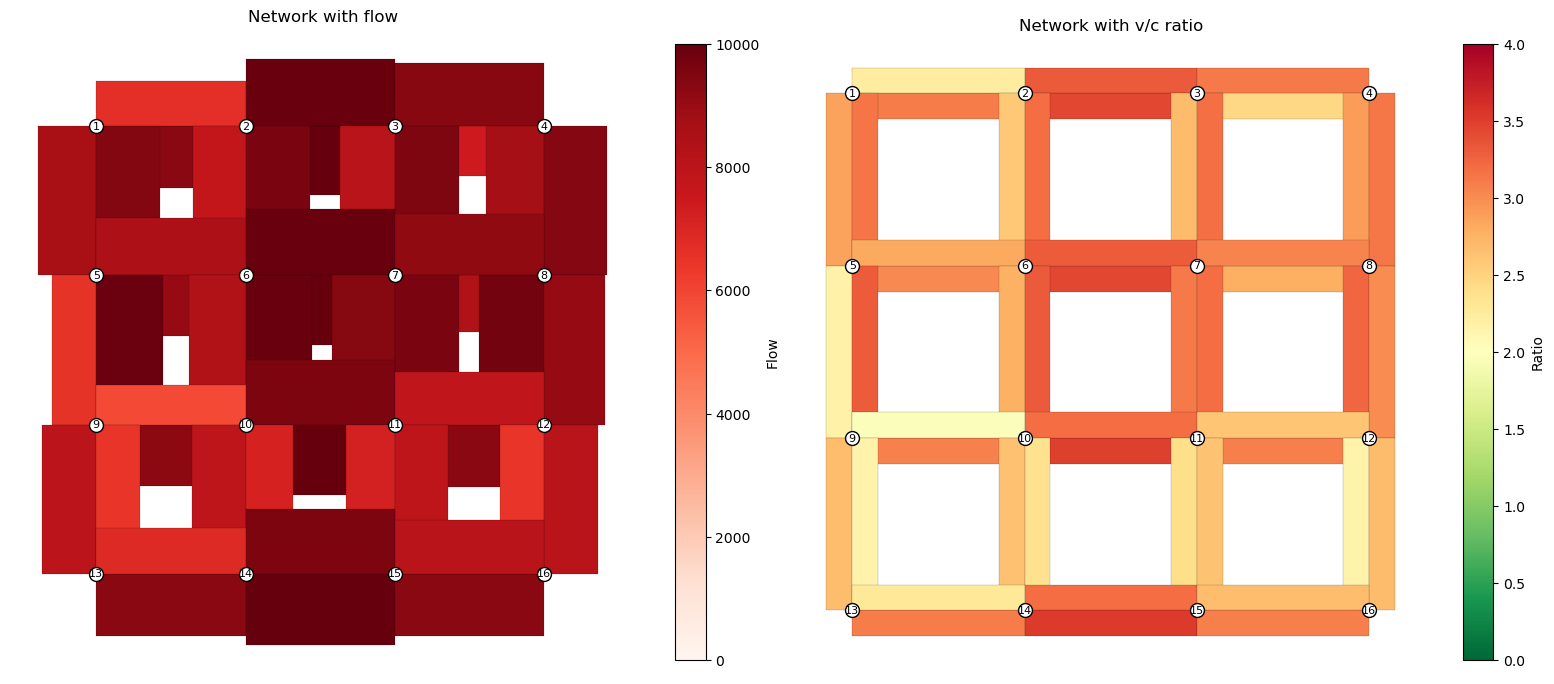

DUE completed in 0.95s | RGAP: 0.000095 | TTT: 156564274291


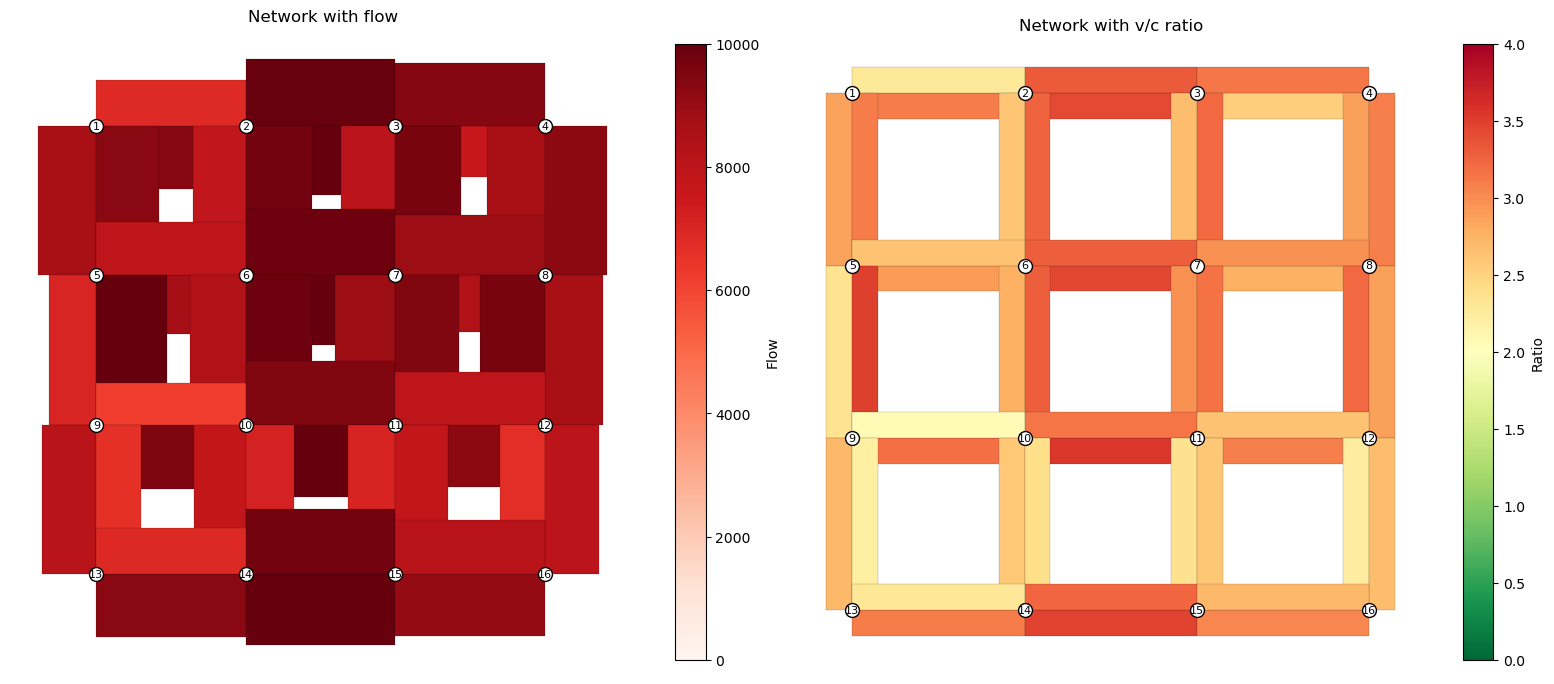

DUE completed in 1.59s | RGAP: 0.000088 | TTT: 156564197131


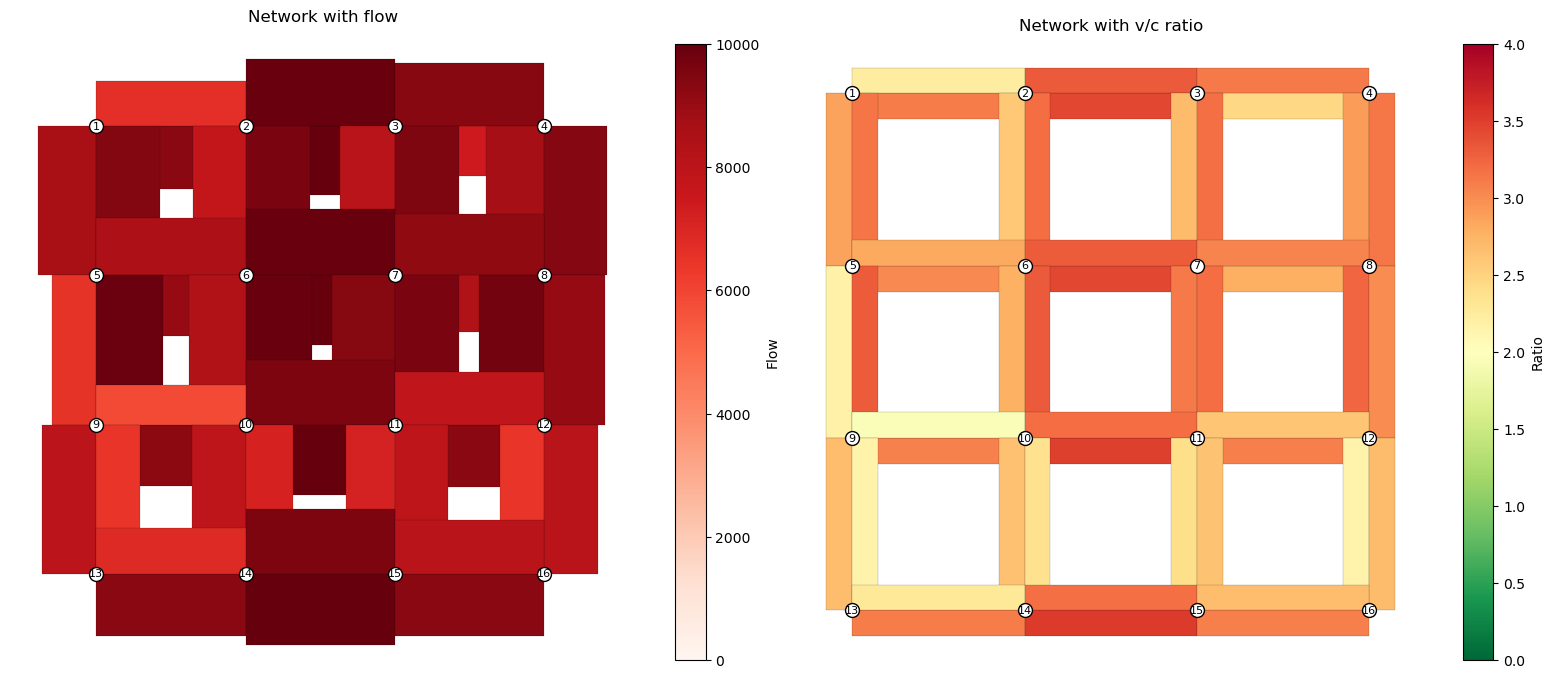

DUE completed in 1.09s | RGAP: 0.000082 | TTT: 156564320322


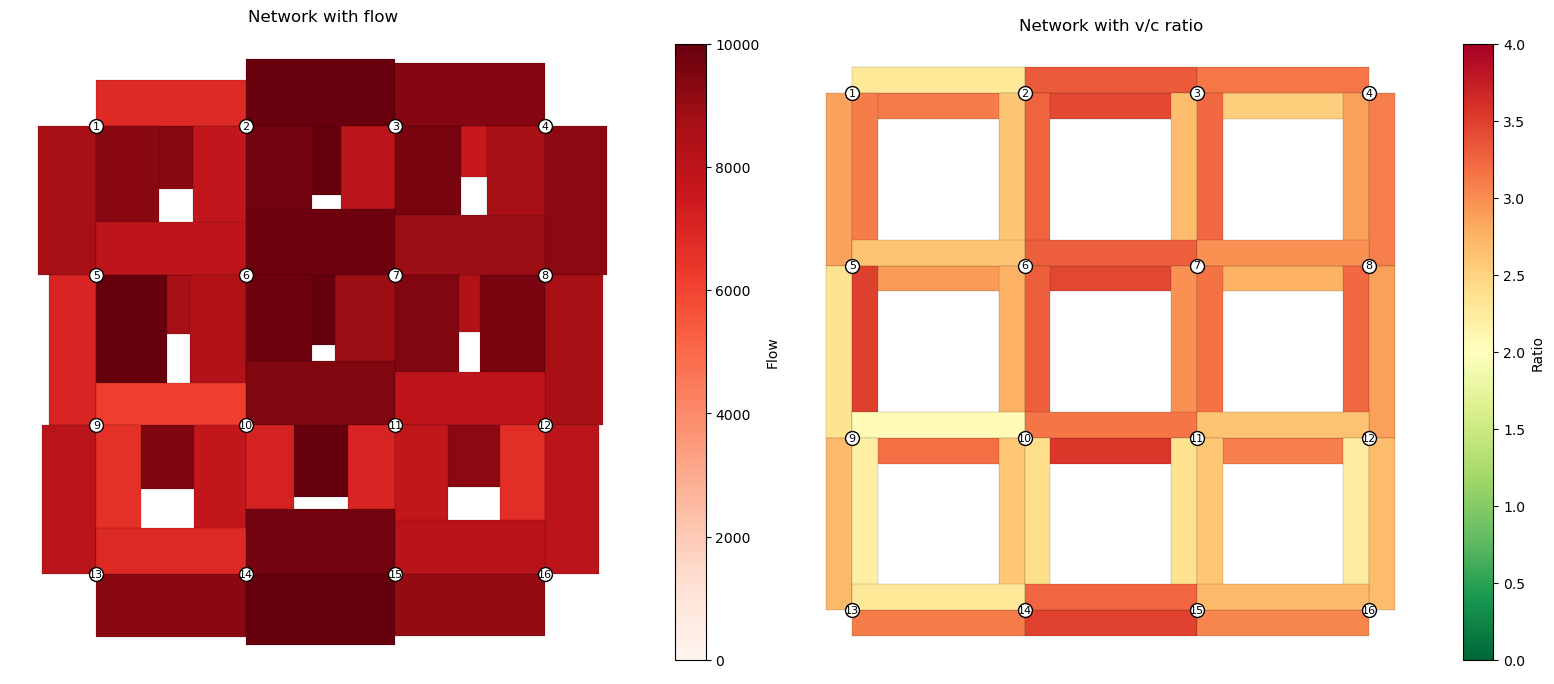

DUE completed in 1.04s | RGAP: 0.000097 | TTT: 156564278176


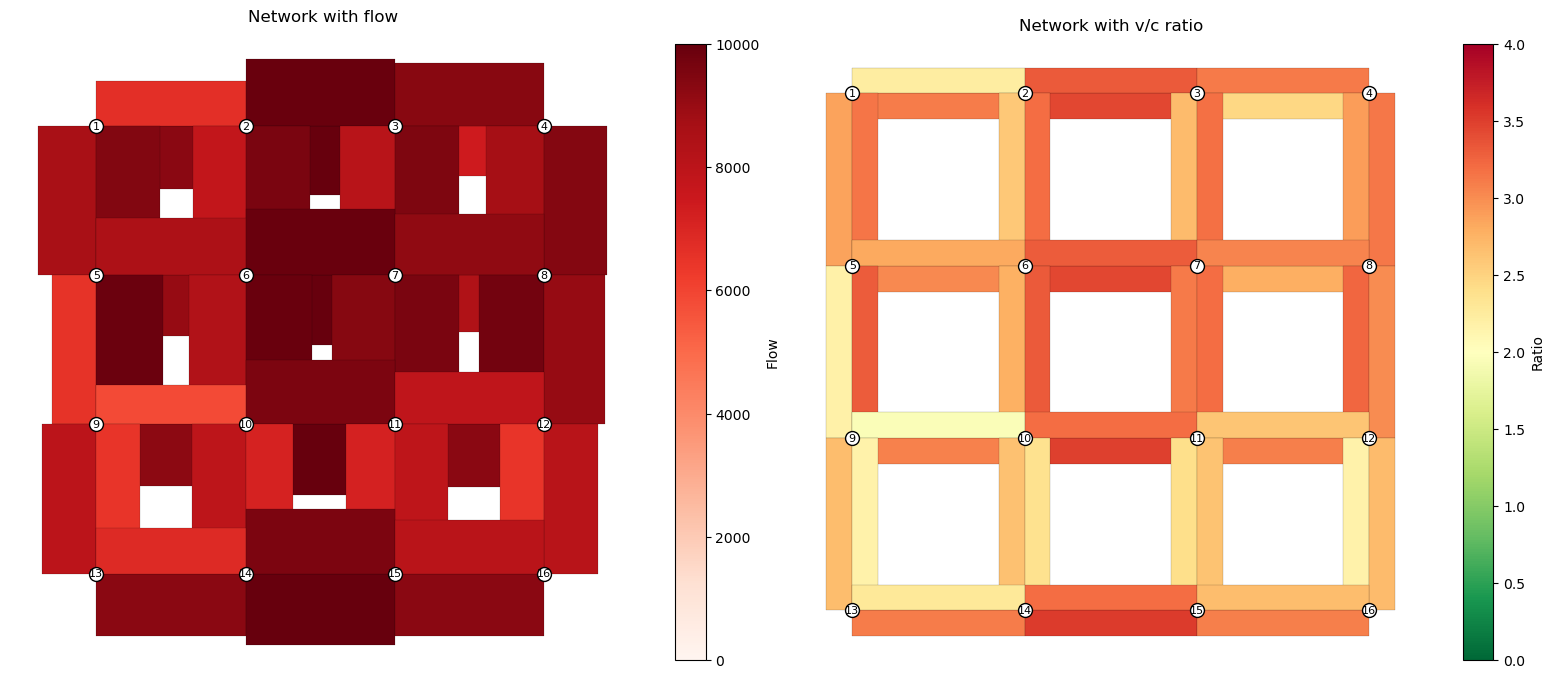

DUE completed in 1.05s | RGAP: 0.000092 | TTT: 156564251247


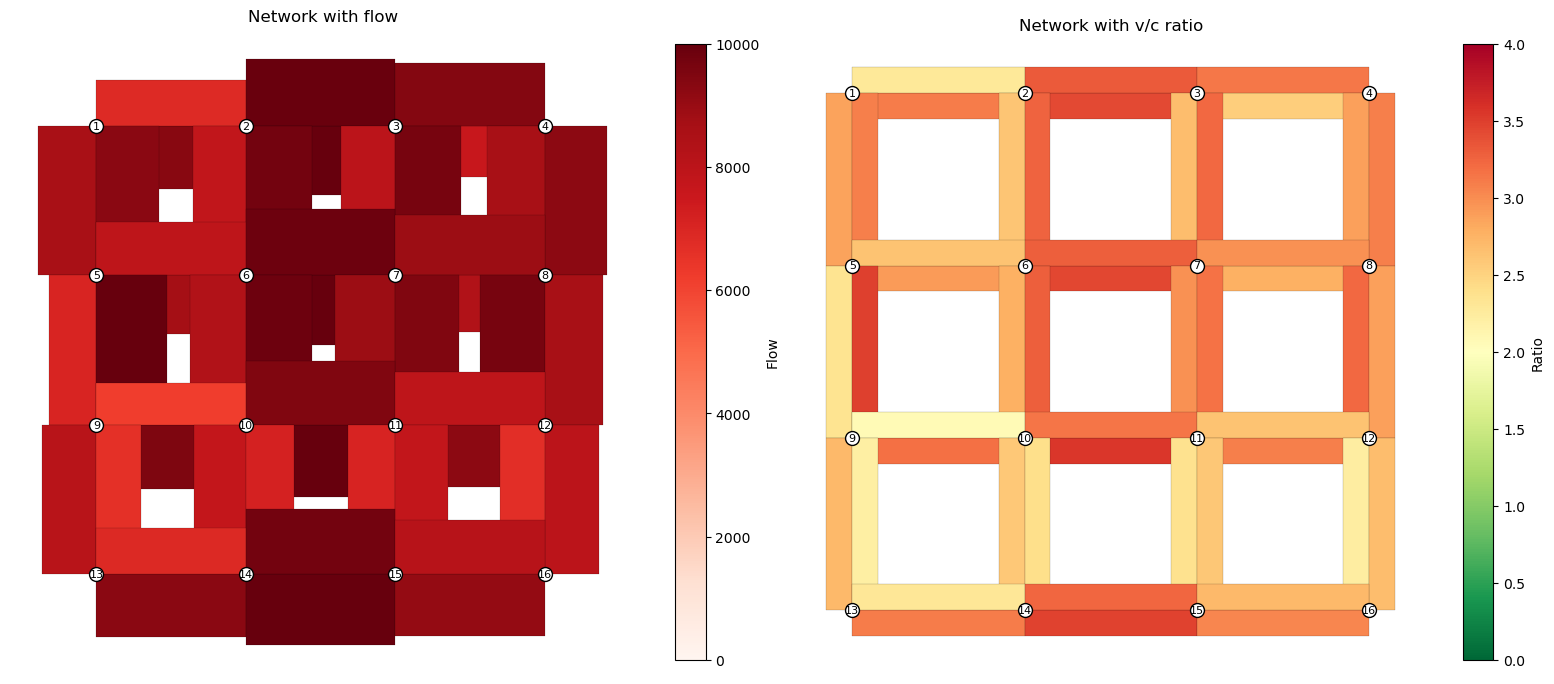

In [99]:
for i in range(40):
    results = ta_due(edge_df, od_matrix, algorithm='bfw', max_iter=500, tolerance=1e-4,
            time_field='free_flow_time', cost_field='congested_time', verbose=True)
    edge_df = calculate_congested_time(results['network'], free_flow_time_name="free_flow_time", congested_time_name="congested_time", flow_name="flow", capacity_name="capacity", alpha=0.15, beta=4)
    fig, axes = plt.subplots(1,2, figsize=(16,8))
    plot_network(edge_df, node_df,
                node_id_col='node',
                node_label=True,
                color_col_num='flow',
                base_width=0.01,
                width_col='flow',
                width_scale=15,
                legend=True,
                title="Network with flow",
                figsize=(8,8),
                cmap='Reds',
                vmax=10000,
                vmin=0,
                ax=axes[0])
    plot_network(edge_df, node_df,
                node_id_col='node',
                node_label=True,
                color_col_num='ratio',
                base_width=5,
                width_col='ratio',
                width_scale=8,
                legend=True,
                title="Network with v/c ratio",
                figsize=(8,8),
                cmap='RdYlGn_r',
                vmax=4,
                vmin=0,
                ax=axes[1])
    plt.show()